# **HackaPUCSP: Previsão de Desempenho no ENEM**

## **Importação das bibliotecas e dos dados**

In [1]:
SEED = 3

from sklearnex import patch_sklearn
patch_sklearn()

import joblib
import skops.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

TP_FAIXA_ETARIA TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  TP_NACIONALIDADE  \
0                3       F                1            1                 1   
1                4       M                1            3                 1   
2                3       M                1            3                 1   
3                2       M                1            3                 1   
4                3       F                1            1                 1   

   TP_ST_CONCLUSAO  TP_ESCOLA  TP_ENSINO  IN_TREINEIRO  CO_MUNICIPIO_ESC  ...  \
0                2          2        1.0             0         4322707.0  ...   
1                2          2        1.0             0         3303500.0  ...   
2                2          2        1.0             0         2408102.0  ...   
3                2          2        1.0             0         2306405.0  ...   
4                2          2        1.0             0         3520509.0  ...   

  Q020  Q021 Q022  Q023  Q024  Q025       ID      MF  NU_ANO CONCEITO  
0    A     A    E     A     B     B  2464336  608.46    2020        C  
1    A     B    B     A     A     A  1983774  362.88    2020        E  
2    A     A    E     A     B     B  1440554  681.82    2020        C  
3    A     A    B     A     A     A  2522015  462.20    2020        E  
4    A     A    D     A     A     B  3274277  506.72    2020        D  

[5 rows x 77 columns]

Verificando se há itens duplicados

In [4]:
train_data[train_data.duplicated(subset='ID', keep='first')]

Empty DataFrame
Columns: [TP_FAIXA_ETARIA, TP_SEXO, TP_ESTADO_CIVIL, TP_COR_RACA, TP_NACIONALIDADE, TP_ST_CONCLUSAO, TP_ESCOLA, TP_ENSINO, IN_TREINEIRO, CO_MUNICIPIO_ESC, NO_MUNICIPIO_ESC, CO_UF_ESC, SG_UF_ESC, TP_DEPENDENCIA_ADM_ESC, TP_LOCALIZACAO_ESC, TP_SIT_FUNC_ESC, CO_MUNICIPIO_PROVA, NO_MUNICIPIO_PROVA, CO_UF_PROVA, SG_UF_PROVA, TP_PRESENCA_CN, TP_PRESENCA_CH, TP_PRESENCA_LC, TP_PRESENCA_MT, CO_PROVA_CN, CO_PROVA_CH, CO_PROVA_LC, CO_PROVA_MT, NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_LC, NU_NOTA_MT, TX_RESPOSTAS_CN, TX_RESPOSTAS_CH, TX_RESPOSTAS_LC, TX_RESPOSTAS_MT, TP_LINGUA, TX_GABARITO_CN, TX_GABARITO_CH, TX_GABARITO_LC, TX_GABARITO_MT, TP_STATUS_REDACAO, NU_NOTA_COMP1, NU_NOTA_COMP2, NU_NOTA_COMP3, NU_NOTA_COMP4, NU_NOTA_COMP5, NU_NOTA_REDACAO, Q001, Q002, Q003, Q004, Q005, Q006, Q007, Q008, Q009, Q010, Q011, Q012, Q013, Q014, Q015, Q016, Q017, Q018, Q019, Q020, Q021, Q022, Q023, Q024, Q025, ID, MF, NU_ANO, CONCEITO]
Index: []

[0 rows x 77 columns]

In [5]:
train_data = train_data.set_index('ID')
train_data.head()

TP_FAIXA_ETARIA TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  \
ID                                                               
2464336                3       F                1            1   
1983774                4       M                1            3   
1440554                3       M                1            3   
2522015                2       M                1            3   
3274277                3       F                1            1   

         TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ESCOLA  TP_ENSINO  \
ID                                                                 
2464336                 1                2          2        1.0   
1983774                 1                2          2        1.0   
1440554                 1                2          2        1.0   
2522015                 1                2          2        1.0   
3274277                 1                2          2        1.0   

         IN_TREINEIRO  CO_MUNICIPIO_ESC  ... Q019  Q020 Q021  Q022  Q023  \
ID                                       ...                               
2464336             0         4322707.0  ...    C     A    A     E     A   
1983774             0         3303500.0  ...    B     A    B     B     A   
1440554             0         2408102.0  ...    C     A    A     E     A   
2522015             0         2306405.0  ...    B     A    A     B     A   
3274277             0         3520509.0  ...    B     A    A     D     A   

         Q024  Q025      MF  NU_ANO CONCEITO  
ID                                            
2464336     B     B  608.46    2020        C  
1983774     A     A  362.88    2020        E  
1440554     B     B  681.82    2020        C  
2522015     A     A  462.20    2020        E  
3274277     A     B  506.72    2020        D  

[5 rows x 76 columns]

**Tipo de colunas**

- **Retirar:** ID, NO_MUNICIPIO_ESC, SG_UF_ESC, NO_MUNICIPIO_PROVA, SG_UF_PROVA, NO_MUNICIPIO_PROVA, SG_UF_PROVA, TX_RESPOSTAS_CN, TX_RESPOSTAS_CH, TX_RESPOSTAS_LC, TX_RESPOSTAS_MT, TX_GABARITO_CN, TX_GABARITO_CH, TX_GABARITO_LC, TX_GABARITO_MT

- **Booleanas:** Q018, Q020, Q021, Q023, Q025

- **Categóricas Ordinais:** TP_FAIXA_ETARIA, Q001, Q002, Q006, Q007, Q008, Q009, Q010, Q011, Q012, Q013, Q014, Q015, Q016, Q017, Q019, Q022, Q024

- **Categóricas Nominais:** Q003, Q004, TP_SEXO, CO_PROVA_CN, CO_PROVA_CH, CO_PROVA_LC, CO_PROVA_MT, CO_MUNICIPIO_PROVA, CO_UF_PROVA, CO_MUNICIPIO_ESC, CO_UF_ESC

- **Numéricas:** TP_SIT_FUNC_ESC, IN_TREINEIRO, TP_PRESENCA_CH, NU_NOTA_CH, NU_NOTA_MT, NU_ANO, NU_NOTA_CN, MF, TP_LINGUA, TP_ENSINO, TP_ST_CONCLUSAO, Q005, NU_NOTA_COMP3, TP_PRESENCA_MT, TP_NACIONALIDADE, TP_PRESENCA_CN, NU_NOTA_COMP5, NU_NOTA_REDACAO, TP_DEPENDENCIA_ADM_ESC, TP_ESCOLA, NU_NOTA_COMP1, NU_NOTA_COMP4, TP_ESTADO_CIVIL, TP_COR_RACA, TP_STATUS_REDACAO, NU_NOTA_COMP2, NU_NOTA_LC, TP_PRESENCA_LC, TP_LOCALIZACAO_ESC

- **Label:** CONCEITO

In [6]:
drop_features = ['NO_MUNICIPIO_ESC', 'SG_UF_ESC', 'NO_MUNICIPIO_PROVA', 'SG_UF_PROVA', 'SG_UF_PROVA', 'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT']

train_data = train_data.drop(columns=drop_features)
train_data.head()

TP_FAIXA_ETARIA TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  \
ID                                                               
2464336                3       F                1            1   
1983774                4       M                1            3   
1440554                3       M                1            3   
2522015                2       M                1            3   
3274277                3       F                1            1   

         TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ESCOLA  TP_ENSINO  \
ID                                                                 
2464336                 1                2          2        1.0   
1983774                 1                2          2        1.0   
1440554                 1                2          2        1.0   
2522015                 1                2          2        1.0   
3274277                 1                2          2        1.0   

         IN_TREINEIRO  CO_MUNICIPIO_ESC  ...  Q019  Q020  Q021  Q022  Q023  \
ID                                       ...                                 
2464336             0         4322707.0  ...     C     A     A     E     A   
1983774             0         3303500.0  ...     B     A     B     B     A   
1440554             0         2408102.0  ...     C     A     A     E     A   
2522015             0         2306405.0  ...     B     A     A     B     A   
3274277             0         3520509.0  ...     B     A     A     D     A   

         Q024  Q025      MF  NU_ANO  CONCEITO  
ID                                             
2464336     B     B  608.46    2020         C  
1983774     A     A  362.88    2020         E  
1440554     B     B  681.82    2020         C  
2522015     A     A  462.20    2020         E  
3274277     A     B  506.72    2020         D  

[5 rows x 64 columns]

In [7]:
boolean_features = ['Q018', 'Q020', 'Q021', 'Q023', 'Q025']
ordinal_features = ['TP_FAIXA_ETARIA', 'Q001', 'Q002', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q019', 'Q022', 'Q024']
nominal_features = ['Q003', 'Q004', 'TP_SEXO', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'CO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'CO_MUNICIPIO_ESC', 'CO_UF_ESC']
discrete_features = ['NU_ANO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'Q005']
continuous_features = list(set(train_data.select_dtypes(exclude='object').columns.values) - set(boolean_features + ordinal_features + nominal_features + discrete_features))
label_features = ['CONCEITO']
all_features = list(set(boolean_features + ordinal_features + nominal_features + discrete_features + continuous_features + label_features))

Não é necessário utilizar inputers

In [8]:
train_data_null = train_data.isna().sum()
train_data_null[train_data_null != 0]

Series([], dtype: int64)

## **Explorando variáveis booleanas**

In [9]:
def explore_boolean(data, variable):
    counts = data[variable].value_counts().sort_index(ascending=True)
    print(counts, '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, ax = plt.subplots(constrained_layout=True)
    sns.countplot(ax=ax, x=data[variable], palette='Blues', order=counts.index)
    plt.show()

### **Q018**

A    135641
B     71750
Name: Q018, dtype: int64 

Nulos: 0 



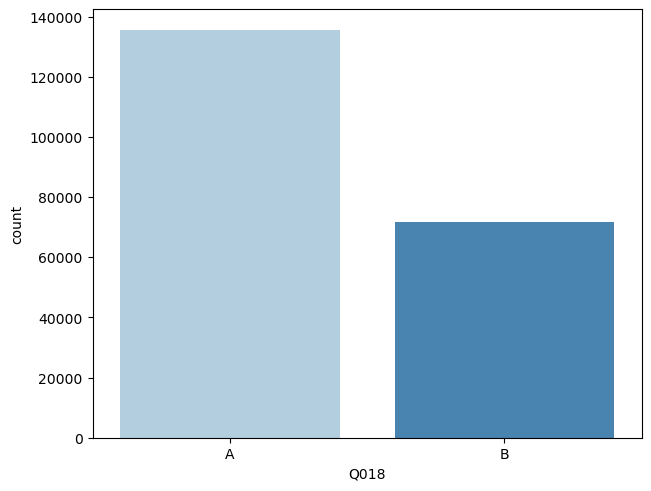

In [10]:
explore_boolean(train_data, 'Q018')

### **Q020**

A    156505
B     50886
Name: Q020, dtype: int64 

Nulos: 0 



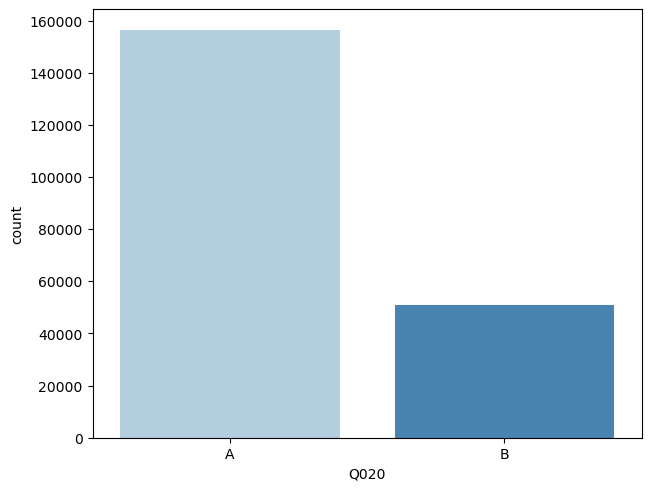

In [11]:
explore_boolean(train_data, 'Q020')

### **Q021**

A    143706
B     63685
Name: Q021, dtype: int64 

Nulos: 0 



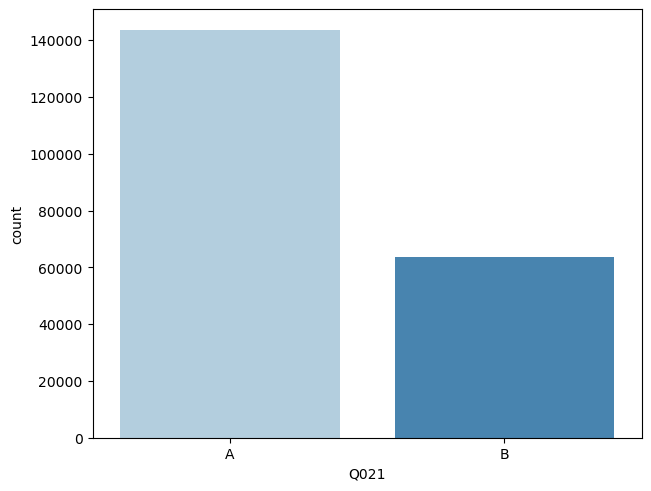

In [12]:
explore_boolean(train_data, 'Q021')

### **Q023**

A    164601
B     42790
Name: Q023, dtype: int64 

Nulos: 0 



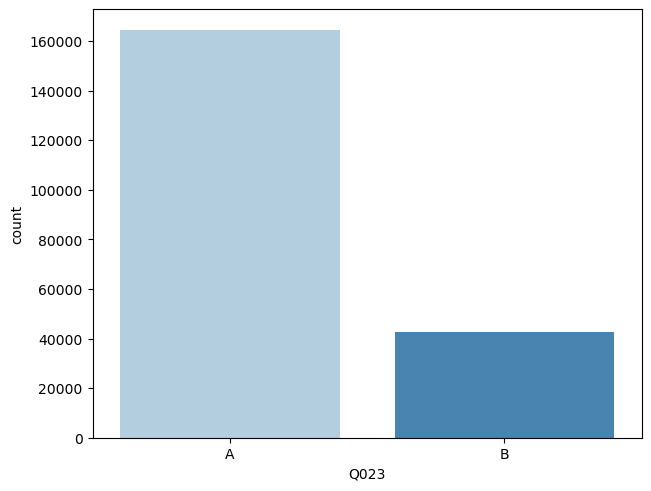

In [13]:
explore_boolean(train_data, 'Q023')

### **Q025**

A     14350
B    193041
Name: Q025, dtype: int64 

Nulos: 0 



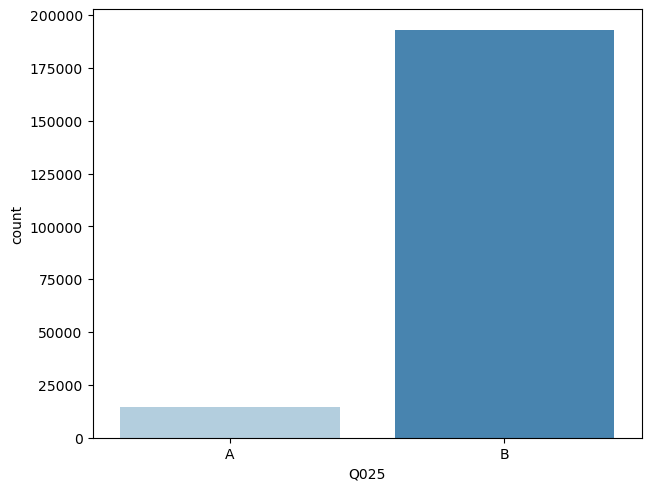

In [14]:
explore_boolean(train_data, 'Q025')

## **Explorando variáveis categóricas ordinais**

In [15]:
def explore_categorical(data, variable):
    counts = data[variable].value_counts().sort_index(ascending=True)
    print(counts, '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, ax = plt.subplots(constrained_layout=True)
    sns.countplot(ax=ax, x=data[variable], palette='Blues', order=counts.index)
    plt.show()

### **TP_FAIXA_ETARIA**

1      2421
2     97713
3     87700
4     14069
5      3588
6       913
7       288
8       134
9        92
10       55
11      188
12       83
13       67
14       32
15       26
16       11
17        6
18        3
19        1
20        1
Name: TP_FAIXA_ETARIA, dtype: int64 

Nulos: 0 



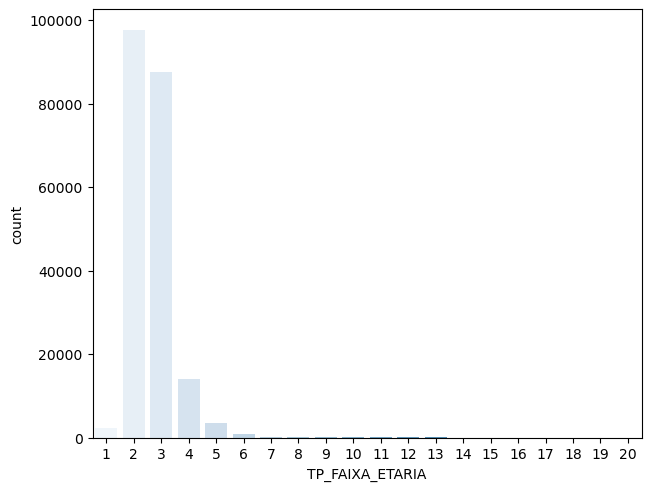

In [16]:
explore_categorical(train_data, 'TP_FAIXA_ETARIA')

### **Q001**

A     4114
B    22805
C    23494
D    23729
E    68195
F    27310
G    21338
H    16406
Name: Q001, dtype: int64 

Nulos: 0 



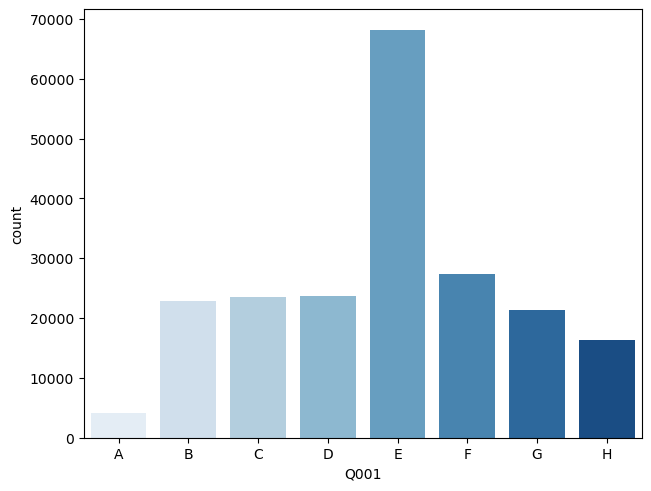

In [17]:
explore_categorical(train_data, 'Q001')

### **Q002**

A     2095
B    13982
C    17880
D    22637
E    76446
F    34830
G    33985
H     5536
Name: Q002, dtype: int64 

Nulos: 0 



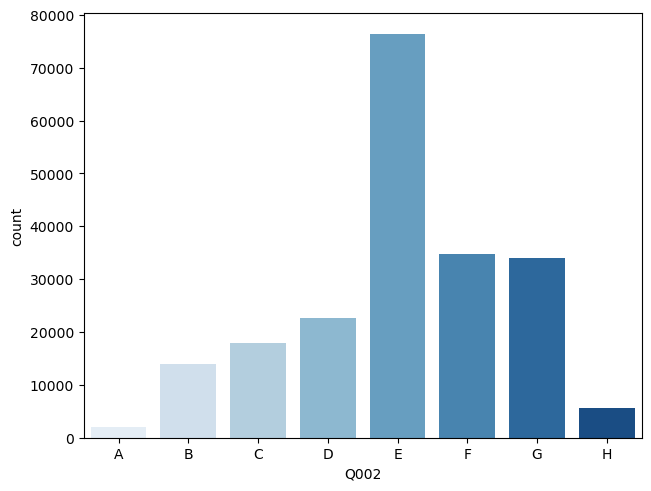

In [18]:
explore_categorical(train_data, 'Q002')

### **Q006**

A     8087
B    43227
C    27569
D    24139
E    14190
F    16856
G    15788
H    13260
I     8520
J     5275
K     4305
L     3740
M     5653
N     3493
O     3997
P     4091
Q     5201
Name: Q006, dtype: int64 

Nulos: 0 



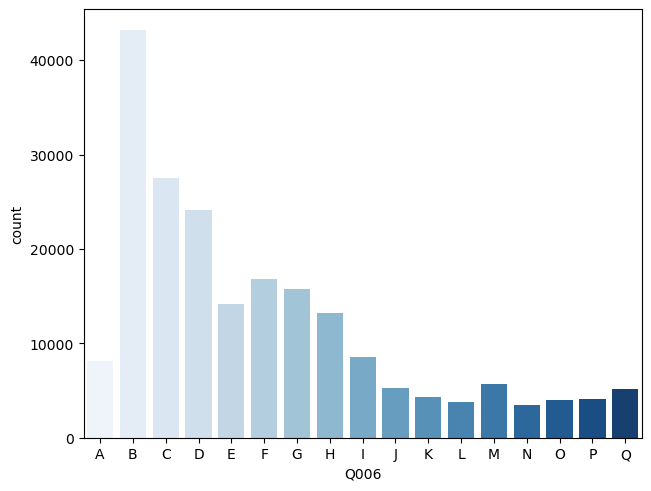

In [19]:
explore_categorical(train_data, 'Q006')

### **Q007**

A    182792
B     12879
C      3248
D      8472
Name: Q007, dtype: int64 

Nulos: 0 



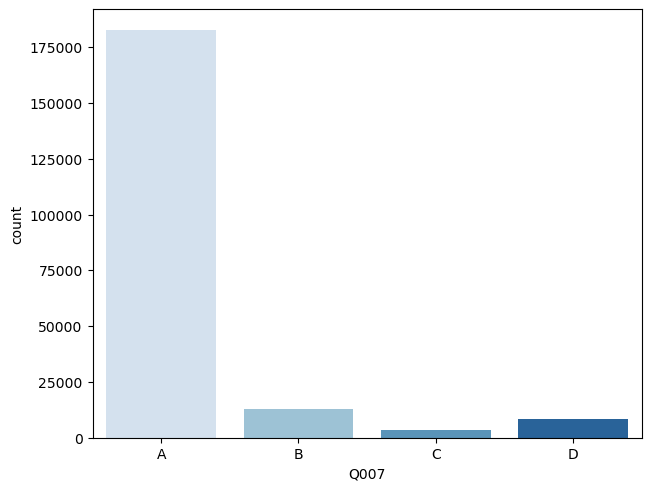

In [20]:
explore_categorical(train_data, 'Q007')

### **Q008**

A       948
B    110984
C     60152
D     22018
E     13289
Name: Q008, dtype: int64 

Nulos: 0 



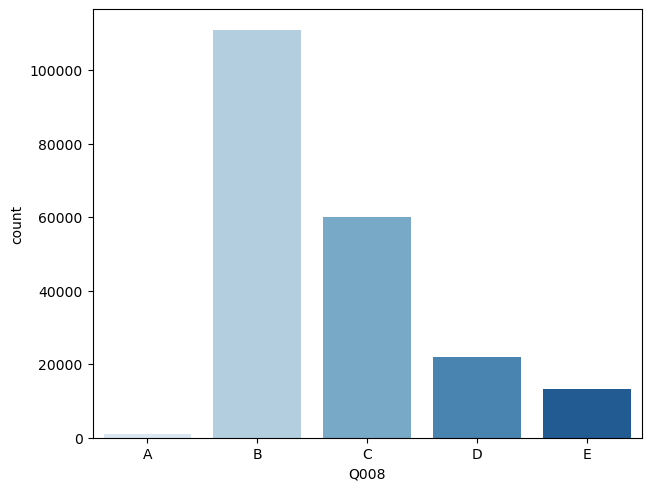

In [21]:
explore_categorical(train_data, 'Q008')

### **Q009**

A      770
B    13357
C    94110
D    82797
E    16357
Name: Q009, dtype: int64 

Nulos: 0 



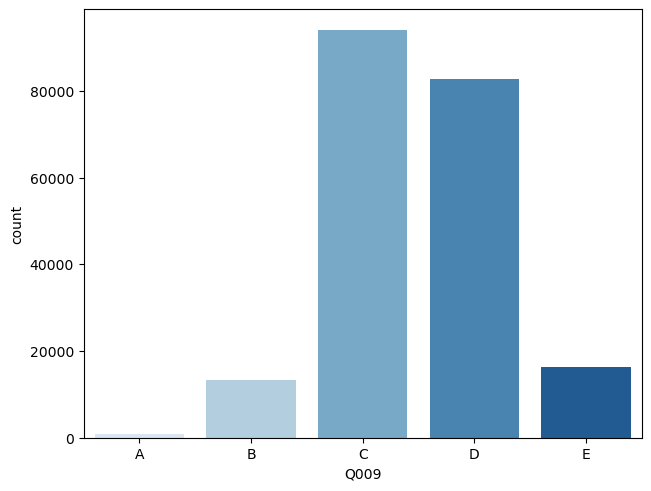

In [22]:
explore_categorical(train_data, 'Q009')

### **Q010**

A    79055
B    94955
C    29037
D     3619
E      725
Name: Q010, dtype: int64 

Nulos: 0 



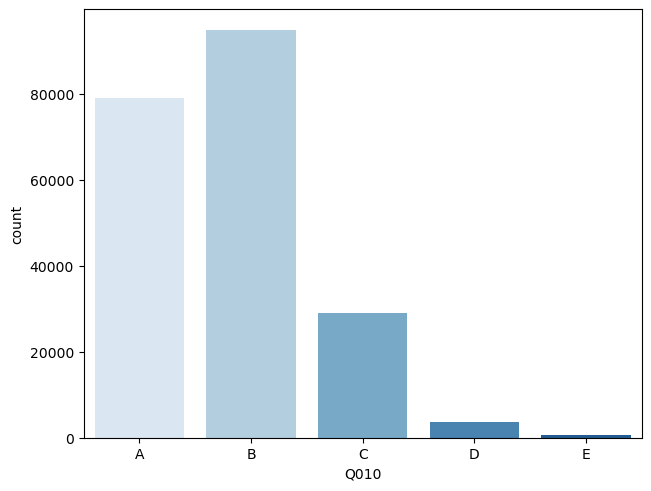

In [23]:
explore_categorical(train_data, 'Q010')

### **Q011**

A    157429
B     44146
C      5197
D       520
E        99
Name: Q011, dtype: int64 

Nulos: 0 



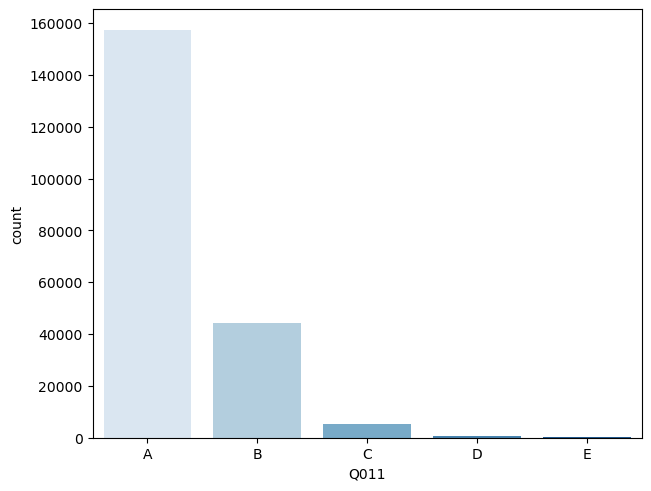

In [24]:
explore_categorical(train_data, 'Q011')

### **Q012**

A      1651
B    189602
C     14775
D      1117
E       246
Name: Q012, dtype: int64 

Nulos: 0 



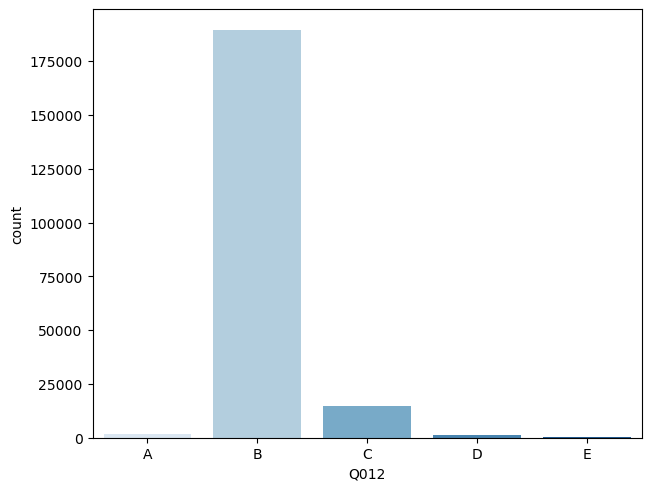

In [25]:
explore_categorical(train_data, 'Q012')

### **Q013**

In [26]:
explore_categorical(train_data, 'Q013')

A     91419
B    104355
C     10054
D      1276
E       287
Name: Q013, dtype: int64 

Nulos: 0 



### **Q014**

A     56303
B    147753
C      3220
D        99
E        16
Name: Q014, dtype: int64 

Nulos: 0 



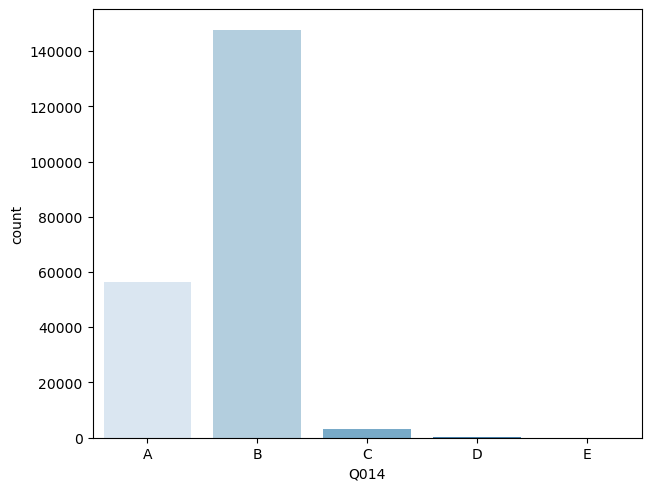

In [27]:
explore_categorical(train_data, 'Q014')

### **Q015**

In [28]:
explore_categorical(train_data, 'Q015')

A    172476
B     34450
C       423
D        32
E        10
Name: Q015, dtype: int64 

Nulos: 0 



### **Q016**

In [29]:
explore_categorical(train_data, 'Q016')

A     80732
B    124426
C      2121
D        96
E        16
Name: Q016, dtype: int64 

Nulos: 0 



### **Q017**

In [30]:
explore_categorical(train_data, 'Q017')

A    196937
B     10245
C       182
D        17
E        10
Name: Q017, dtype: int64 

Nulos: 0 



### **Q019**

A      6277
B    116284
C     50323
D     22406
E     12101
Name: Q019, dtype: int64 

Nulos: 0 



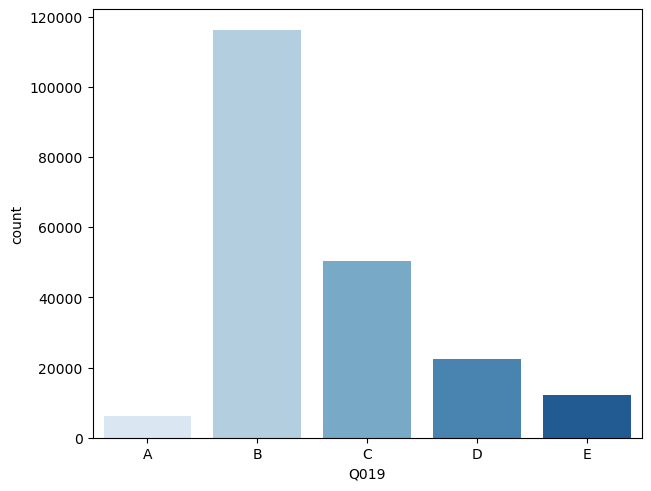

In [31]:
explore_categorical(train_data, 'Q019')

### **Q022**

In [32]:
explore_categorical(train_data, 'Q022')

A     3348
B    21356
C    46323
D    72241
E    64123
Name: Q022, dtype: int64 

Nulos: 0 



### **Q024**

In [33]:
explore_categorical(train_data, 'Q024')

A    70260
B    86319
C    30031
D    13322
E     7459
Name: Q024, dtype: int64 

Nulos: 0 



## **Explorando variáveis categóricas nominais**

In [34]:
def explore_categorical(data, variable):
    counts = data[variable].value_counts().sort_index(ascending=True)
    print(counts, '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, ax = plt.subplots(constrained_layout=True)
    sns.countplot(ax=ax, x=data[variable], palette='Blues', order=counts.index)
    plt.show()

### **Q003**

A    26366
B    36041
C    46268
D    55573
E    22938
F    20205
Name: Q003, dtype: int64 

Nulos: 0 



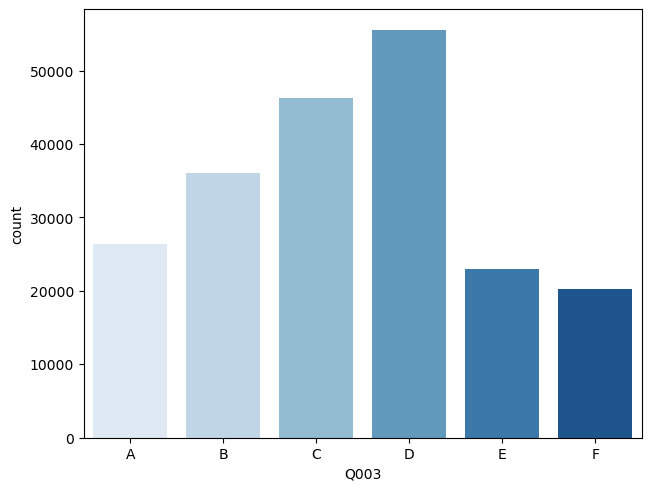

In [35]:
explore_categorical(train_data, 'Q003')

### **Q004**

A    20485
B    73321
C    12935
D    67056
E    16847
F    16747
Name: Q004, dtype: int64 

Nulos: 0 



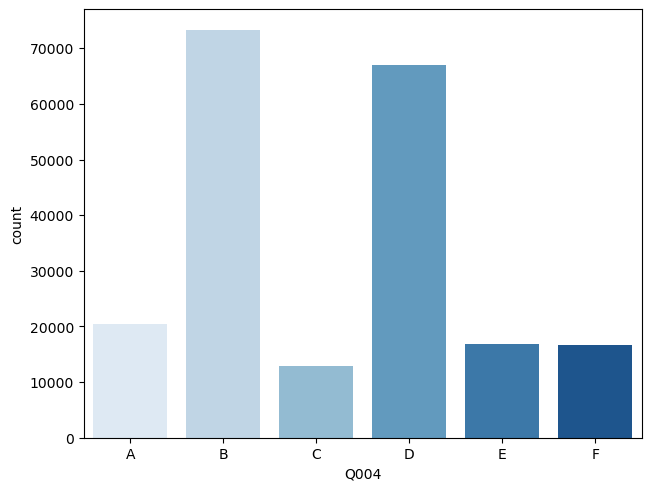

In [36]:
explore_categorical(train_data, 'Q004')

### **TP_SEXO**

F    117206
M     90185
Name: TP_SEXO, dtype: int64 

Nulos: 0 



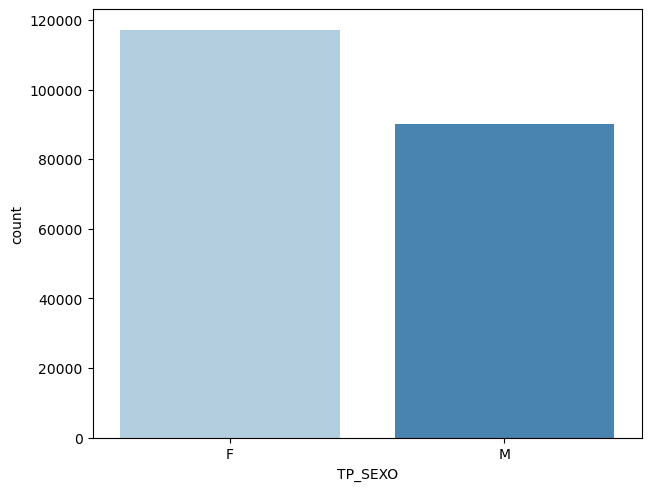

In [37]:
explore_categorical(train_data, 'TP_SEXO')

### **CO_PROVA_CN**

In [38]:
explore_categorical(train_data, 'CO_PROVA_CN')

909.0     50383
910.0     51331
911.0     50450
912.0     50743
916.0        23
917.0        96
989.0        33
990.0        25
991.0        31
992.0        36
1011.0      980
1012.0      952
1013.0      942
1014.0      985
1045.0       89
1046.0       92
1047.0       94
1048.0      106
Name: CO_PROVA_CN, dtype: int64 

Nulos: 0 



### **CO_PROVA_CH**

In [39]:
explore_categorical(train_data, 'CO_PROVA_CH')

879.0     50697
880.0     51060
881.0     50365
882.0     50736
886.0        23
887.0        96
959.0        44
960.0        50
961.0        43
962.0        48
999.0       953
1000.0      981
1001.0      979
1002.0      935
1015.0       91
1016.0       95
1017.0       89
1018.0      106
Name: CO_PROVA_CH, dtype: int64 

Nulos: 0 



### **CO_PROVA_LC**

889.0     50697
890.0     51060
891.0     50736
892.0     50365
896.0        23
897.0        96
969.0        44
970.0        50
971.0        48
972.0        43
1003.0      953
1004.0      981
1005.0      979
1006.0      935
1025.0       91
1026.0       95
1027.0      106
1028.0       89
Name: CO_PROVA_LC, dtype: int64 

Nulos: 0 



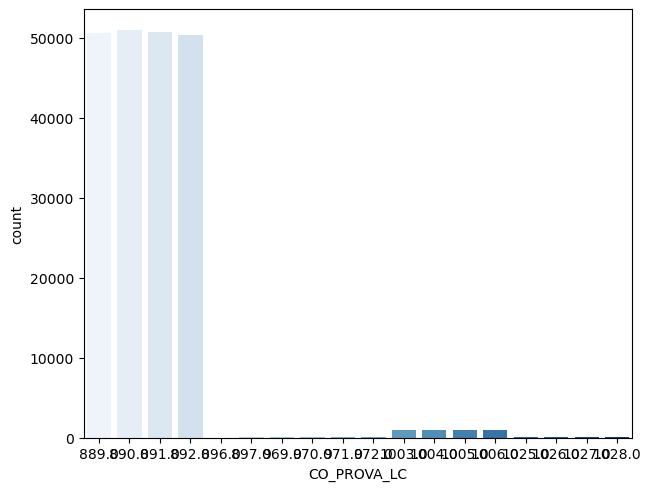

In [40]:
explore_categorical(train_data, 'CO_PROVA_LC')

### **CO_PROVA_MT**

In [41]:
explore_categorical(train_data, 'CO_PROVA_MT')

899.0     50383
900.0     51331
901.0     50743
902.0     50450
906.0        23
907.0        96
979.0        33
980.0        25
981.0        36
982.0        31
1007.0      980
1008.0      952
1009.0      942
1010.0      985
1035.0       89
1036.0       92
1037.0      106
1038.0       94
Name: CO_PROVA_MT, dtype: int64 

Nulos: 0 



### **CO_MUNICIPIO_PROVA**

1100015      11
1100023     106
1100049     135
1100056      25
1100064      26
           ... 
5220603      79
5221403     234
5221601     121
5221858     170
5300108    4884
Name: CO_MUNICIPIO_PROVA, Length: 1746, dtype: int64 

Nulos: 0 



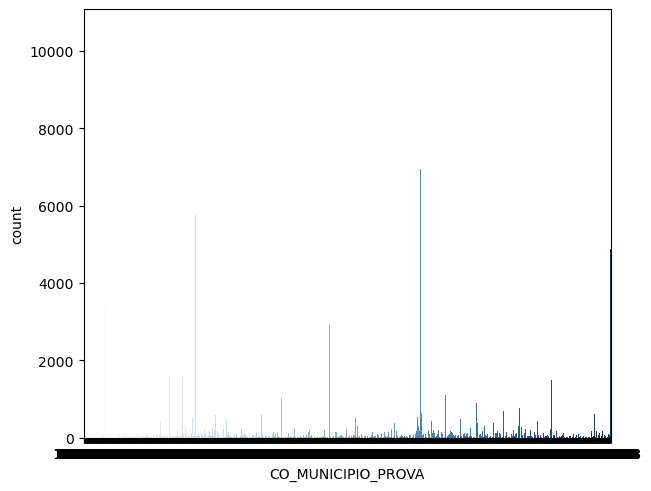

In [42]:
explore_categorical(train_data, 'CO_MUNICIPIO_PROVA')

### **CO_UF_PROVA**

11     1650
12      774
13     5383
14      431
15     7166
16      749
17     1567
21     5712
22     3907
23    20242
24     3797
25     4463
26    10186
27     2982
28     2360
29    11871
31    17456
32     4641
33    15148
35    39359
41    11584
42     6978
43     9695
50     2717
51     3280
52     8409
53     4884
Name: CO_UF_PROVA, dtype: int64 

Nulos: 0 



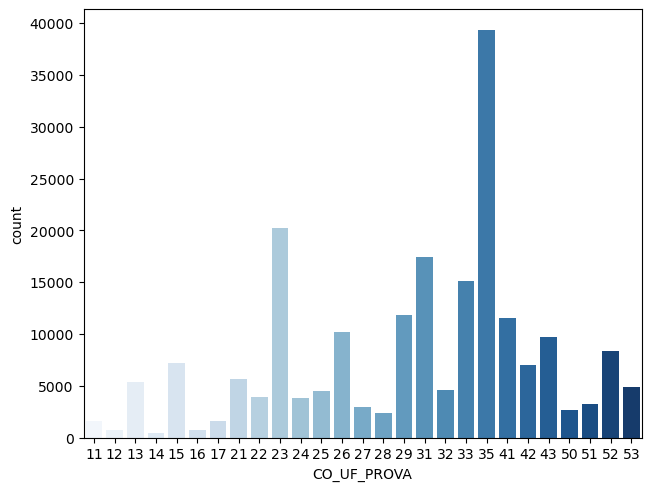

In [43]:
explore_categorical(train_data, 'CO_UF_PROVA')

### **CO_MUNICIPIO_ESC**

1100015.0      11
1100023.0      98
1100031.0       3
1100049.0     138
1100056.0      10
             ... 
5222005.0      11
5222054.0       4
5222203.0       3
5222302.0       9
5300108.0    4954
Name: CO_MUNICIPIO_ESC, Length: 5128, dtype: int64 

Nulos: 0 



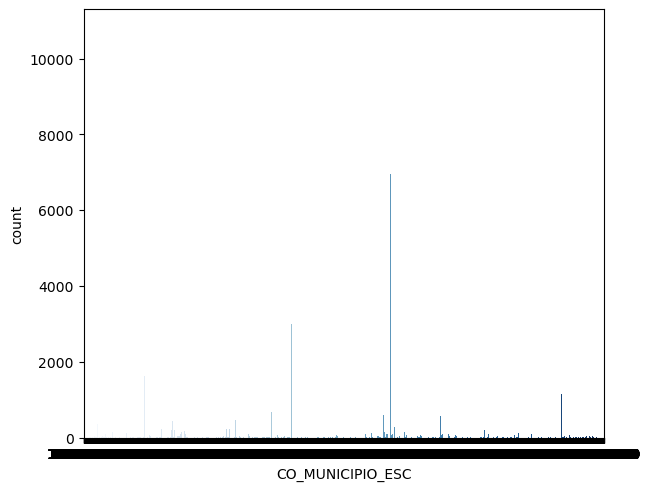

In [44]:
explore_categorical(train_data, 'CO_MUNICIPIO_ESC')

### **CO_UF_ESC**

11.0     1649
12.0      760
13.0     5398
14.0      429
15.0     7198
16.0      736
17.0     1579
21.0     5703
22.0     3921
23.0    20340
24.0     3714
25.0     4473
26.0    10149
27.0     3045
28.0     2305
29.0    11885
31.0    17468
32.0     4662
33.0    15192
35.0    39275
41.0    11621
42.0     6922
43.0     9680
50.0     2700
51.0     3282
52.0     8351
53.0     4954
Name: CO_UF_ESC, dtype: int64 

Nulos: 0 



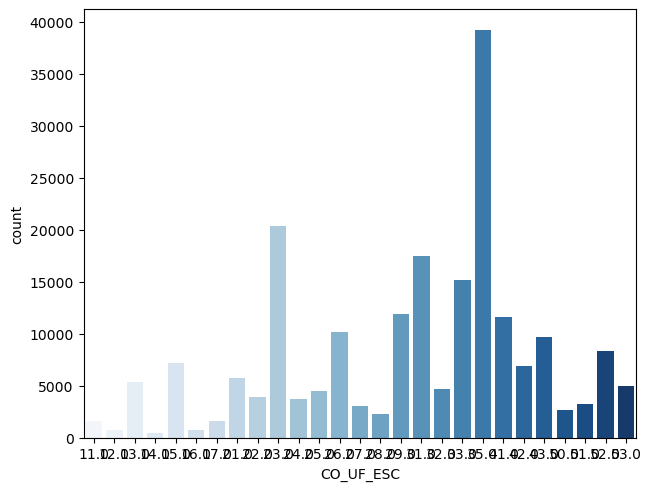

In [45]:
explore_categorical(train_data, 'CO_UF_ESC')

## **Explorando variáveis numéricas discretas**

In [46]:
def explore_discrete(data, variable):
    print(data[variable].value_counts(), '\n')
    print(data[variable].describe(), '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, axs = plt.subplots(nrows=2, constrained_layout=True)
    
    sns.boxplot(ax=axs[0], x=data[variable], palette='Blues')
    sns.histplot(ax=axs[1], data=data[variable], kde=True)
    
    fig.suptitle(variable)
    axs[0].set_title('Boxplot')
    axs[1].set_title('Histograma')
    
    plt.show()

### **NU_ANO**

2020    207391
Name: NU_ANO, dtype: int64 

count    207391.0
mean       2020.0
std           0.0
min        2020.0
25%        2020.0
50%        2020.0
75%        2020.0
max        2020.0
Name: NU_ANO, dtype: float64 

Nulos: 0 



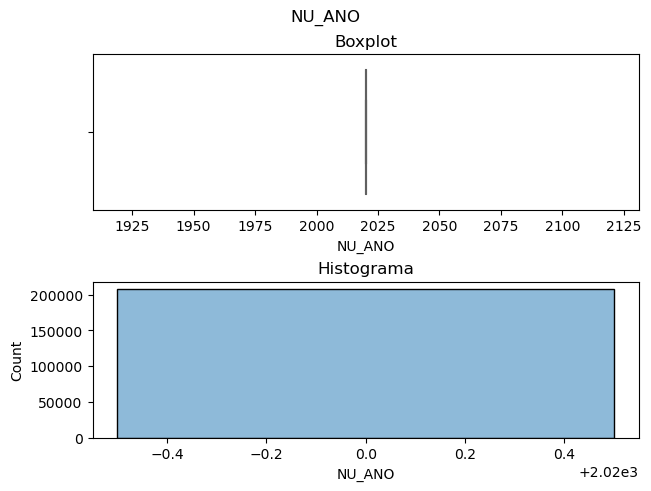

In [47]:
explore_discrete(train_data, 'NU_ANO')

### **TP_ESTADO_CIVIL**

1    199603
0      5801
3      1141
2       808
4        38
Name: TP_ESTADO_CIVIL, dtype: int64 

count    207391.000000
mean          0.987478
std           0.235301
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: TP_ESTADO_CIVIL, dtype: float64 

Nulos: 0 



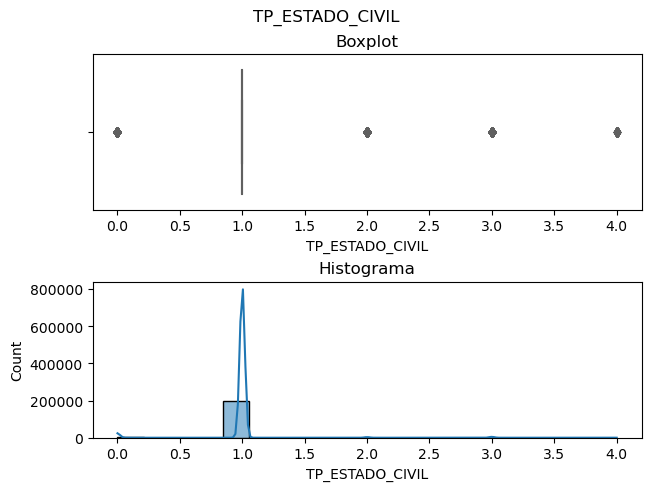

In [48]:
explore_discrete(train_data, 'TP_ESTADO_CIVIL')

### **TP_COR_RACA**

1    101848
3     78745
2     18102
0      4069
4      3853
5       774
Name: TP_COR_RACA, dtype: int64 

count    207391.000000
mean          1.897715
std           1.023089
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max           5.000000
Name: TP_COR_RACA, dtype: float64 

Nulos: 0 



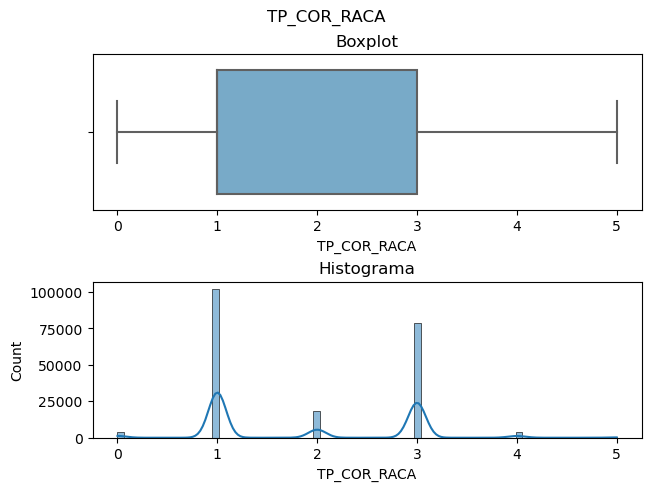

In [49]:
explore_discrete(train_data, 'TP_COR_RACA')

### **TP_NACIONALIDADE**

1    203104
2      3312
4       565
3       252
0       158
Name: TP_NACIONALIDADE, dtype: int64 

count    207391.000000
mean          1.025811
std           0.213178
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: TP_NACIONALIDADE, dtype: float64 

Nulos: 0 



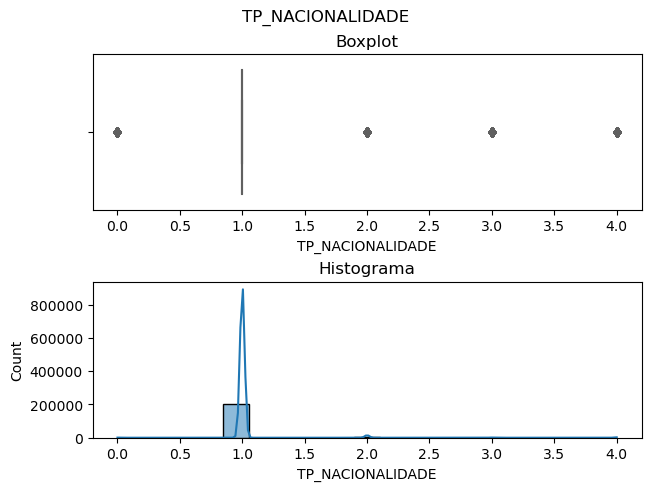

In [50]:
explore_discrete(train_data, 'TP_NACIONALIDADE')

### **TP_ST_CONCLUSAO**

2    207391
Name: TP_ST_CONCLUSAO, dtype: int64 

count    207391.0
mean          2.0
std           0.0
min           2.0
25%           2.0
50%           2.0
75%           2.0
max           2.0
Name: TP_ST_CONCLUSAO, dtype: float64 

Nulos: 0 



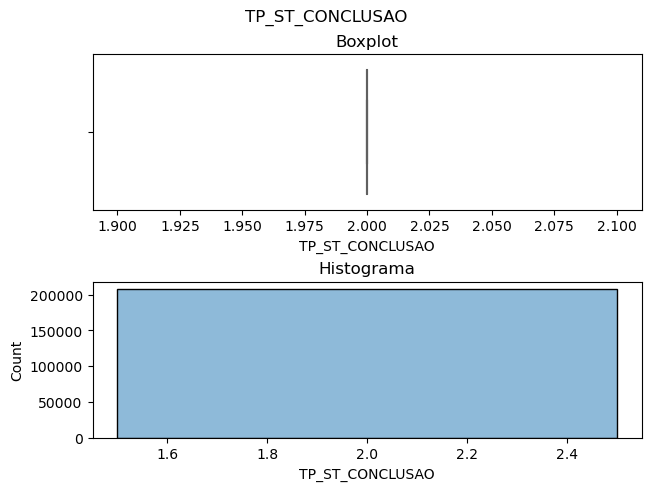

In [51]:
explore_discrete(train_data, 'TP_ST_CONCLUSAO')

### **TP_ESCOLA**

2    152570
3     54821
Name: TP_ESCOLA, dtype: int64 

count    207391.000000
mean          2.264336
std           0.440980
min           2.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: TP_ESCOLA, dtype: float64 

Nulos: 0 



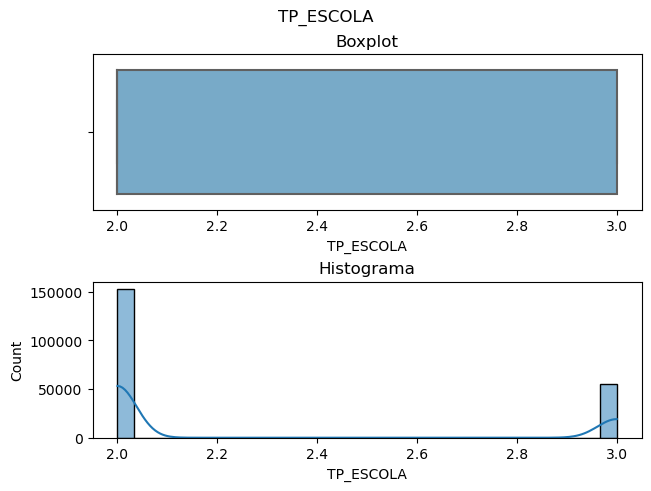

In [52]:
explore_discrete(train_data, 'TP_ESCOLA')

### **TP_ENSINO**

1.0    206564
2.0       827
Name: TP_ENSINO, dtype: int64 

count    207391.000000
mean          1.003988
std           0.063022
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: TP_ENSINO, dtype: float64 

Nulos: 0 



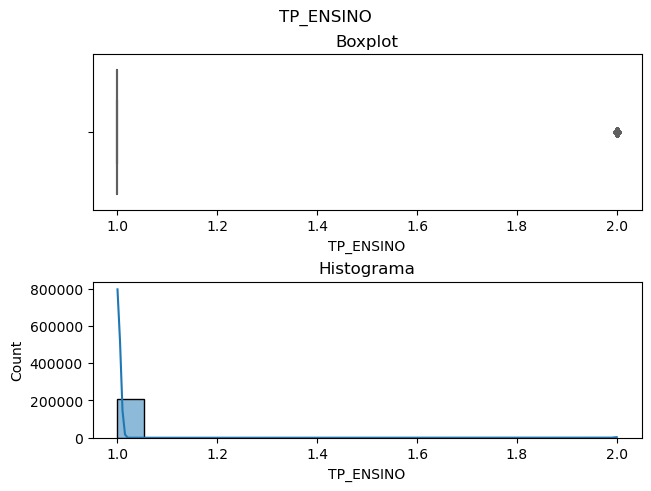

In [53]:
explore_discrete(train_data, 'TP_ENSINO')

### **IN_TREINEIRO**

0    207391
Name: IN_TREINEIRO, dtype: int64 

count    207391.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: IN_TREINEIRO, dtype: float64 

Nulos: 0 



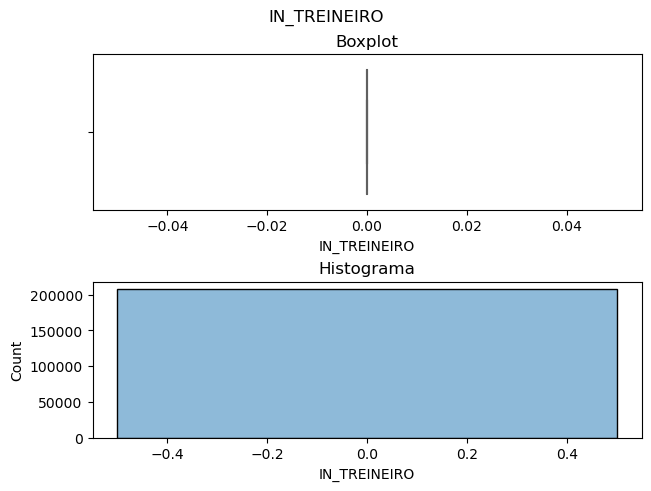

In [54]:
explore_discrete(train_data, 'IN_TREINEIRO')

### **TP_DEPENDENCIA_ADM_ESC**

In [55]:
explore_discrete(train_data, 'TP_DEPENDENCIA_ADM_ESC')

2.0    123489
4.0     67974
1.0     14300
3.0      1628
Name: TP_DEPENDENCIA_ADM_ESC, dtype: int64 

count    207391.000000
mean          2.594413
std           1.017109
min           1.000000
25%           2.000000
50%           2.000000
75%           4.000000
max           4.000000
Name: TP_DEPENDENCIA_ADM_ESC, dtype: float64 

Nulos: 0 



### **TP_LOCALIZACAO_ESC**

1.0    200958
2.0      6433
Name: TP_LOCALIZACAO_ESC, dtype: int64 

count    207391.000000
mean          1.031019
std           0.173369
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: TP_LOCALIZACAO_ESC, dtype: float64 

Nulos: 0 



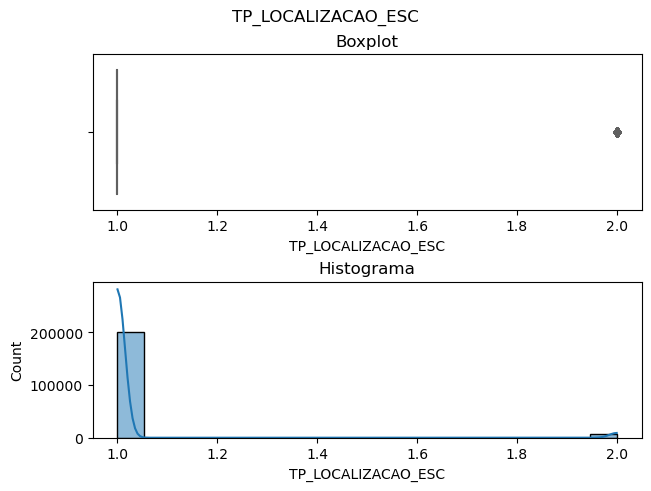

In [56]:
explore_discrete(train_data, 'TP_LOCALIZACAO_ESC')

### **TP_SIT_FUNC_ESC**

1.0    205749
4.0       834
2.0       597
3.0       211
Name: TP_SIT_FUNC_ESC, dtype: int64 

count    207391.000000
mean          1.016978
std           0.207009
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: TP_SIT_FUNC_ESC, dtype: float64 

Nulos: 0 



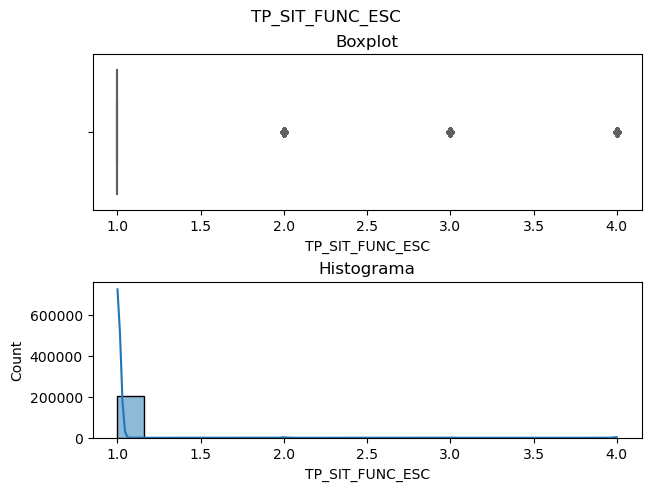

In [57]:
explore_discrete(train_data, 'TP_SIT_FUNC_ESC')

### **TP_PRESENCA_CN**

1    207391
Name: TP_PRESENCA_CN, dtype: int64 

count    207391.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: TP_PRESENCA_CN, dtype: float64 

Nulos: 0 



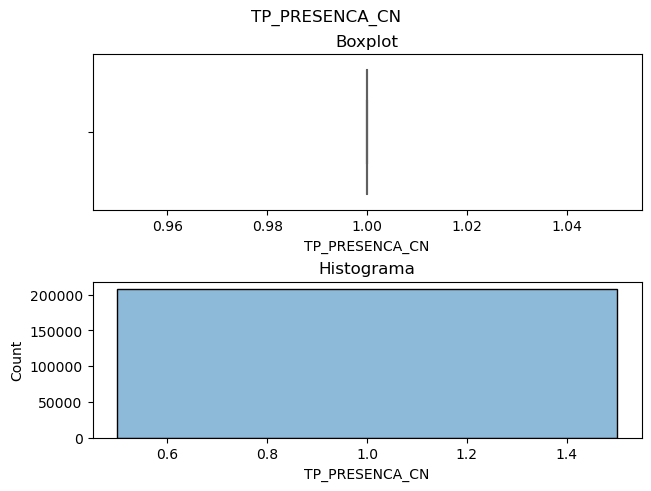

In [58]:
explore_discrete(train_data, 'TP_PRESENCA_CN')

### **TP_PRESENCA_CH**

In [59]:
explore_discrete(train_data, 'TP_PRESENCA_CH')

1    207391
Name: TP_PRESENCA_CH, dtype: int64 

count    207391.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: TP_PRESENCA_CH, dtype: float64 

Nulos: 0 



### **TP_PRESENCA_LC**

1    207391
Name: TP_PRESENCA_LC, dtype: int64 

count    207391.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: TP_PRESENCA_LC, dtype: float64 

Nulos: 0 



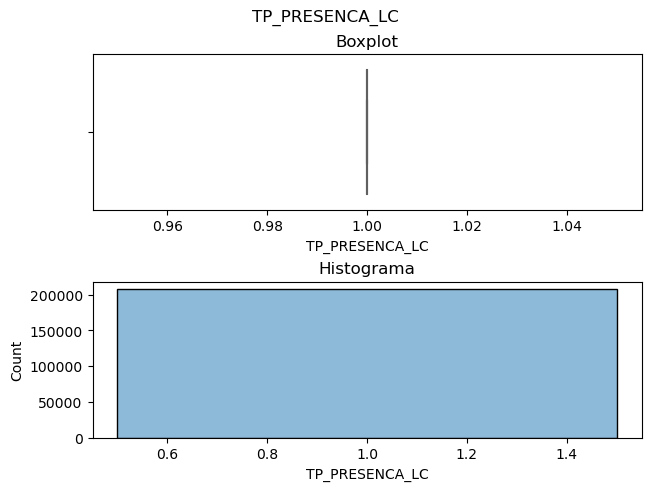

In [60]:
explore_discrete(train_data, 'TP_PRESENCA_LC')

### **TP_PRESENCA_MT**

1    207391
Name: TP_PRESENCA_MT, dtype: int64 

count    207391.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: TP_PRESENCA_MT, dtype: float64 

Nulos: 0 



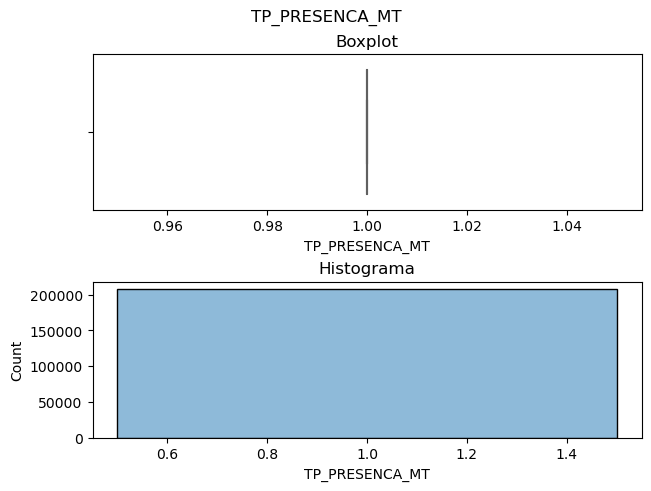

In [61]:
explore_discrete(train_data, 'TP_PRESENCA_MT')

### **TP_LINGUA**

0    130771
1     76620
Name: TP_LINGUA, dtype: int64 

count    207391.000000
mean          0.369447
std           0.482656
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: TP_LINGUA, dtype: float64 

Nulos: 0 



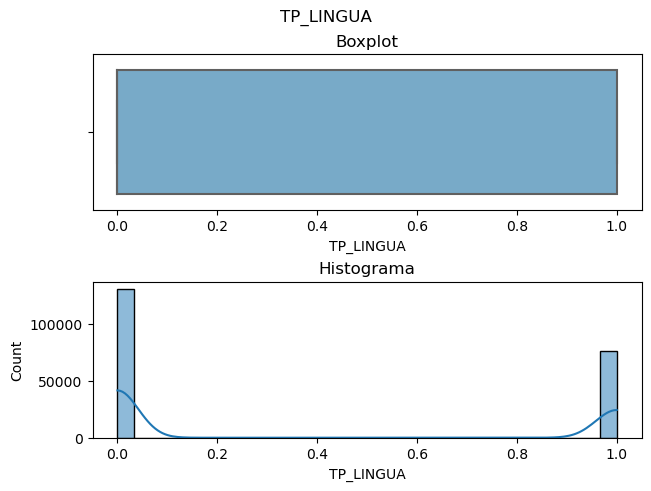

In [62]:
explore_discrete(train_data, 'TP_LINGUA')

### **TP_STATUS_REDACAO**

1.0    200964
4.0      2877
6.0      2008
3.0       710
8.0       454
9.0       151
2.0       138
7.0        89
Name: TP_STATUS_REDACAO, dtype: int64 

count    207391.000000
mean          1.121264
std           0.732036
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: TP_STATUS_REDACAO, dtype: float64 

Nulos: 0 



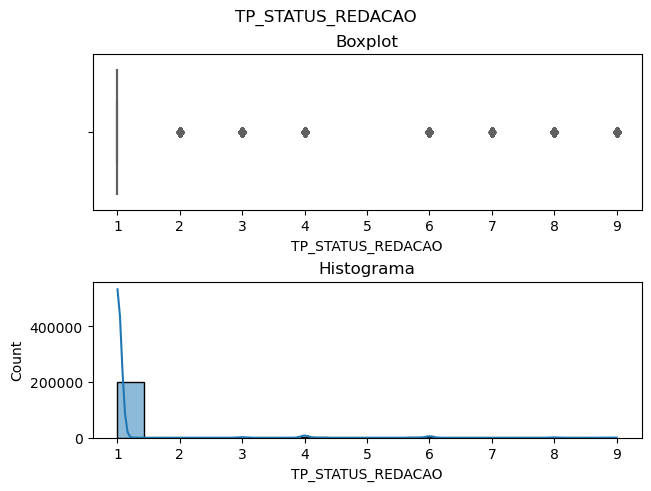

In [63]:
explore_discrete(train_data, 'TP_STATUS_REDACAO')

### **Q005**

4.0     81433
3.0     58345
5.0     33204
2.0     18793
6.0      9868
7.0      3174
8.0      1181
1.0       504
9.0       439
10.0      230
11.0       92
12.0       54
13.0       26
14.0       19
20.0       10
15.0        5
16.0        4
18.0        4
17.0        3
19.0        3
Name: Q005, dtype: int64 

count    207391.000000
mean          3.880520
std           1.186911
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max          20.000000
Name: Q005, dtype: float64 

Nulos: 0 



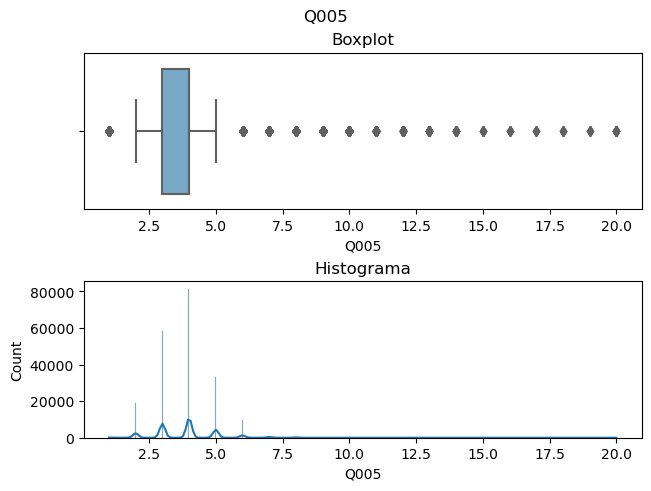

In [64]:
explore_discrete(train_data, 'Q005')

## **Explorando variáveis numéricas contínuas**

In [65]:
def explore_continuous(data, variable):
    print(data[variable].describe(), '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, axs = plt.subplots(nrows=2, constrained_layout=True)
    
    sns.boxplot(ax=axs[0], x=data[variable], palette='Blues')
    sns.histplot(ax=axs[1], data=data[variable], kde=True)
    
    fig.suptitle(variable)
    axs[0].set_title('Boxplot')
    axs[1].set_title('Histograma')
    
    plt.show()

### **NU_NOTA_COMP3**

count    207391.000000
mean        117.671259
std          35.984424
min           0.000000
25%         100.000000
50%         120.000000
75%         140.000000
max         200.000000
Name: NU_NOTA_COMP3, dtype: float64 

Nulos: 0 



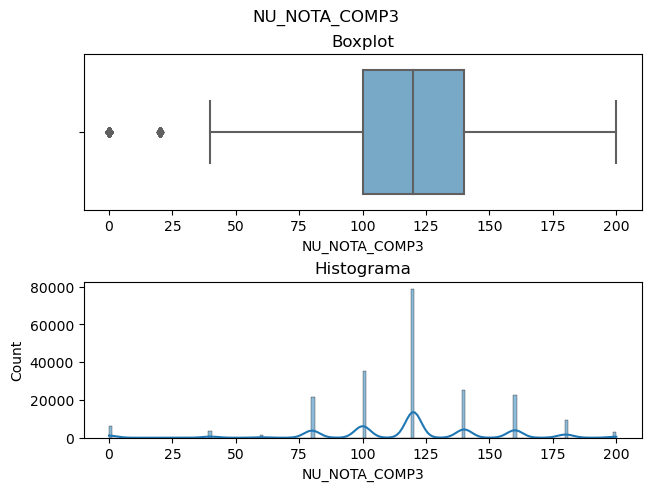

In [66]:
explore_continuous(train_data, 'NU_NOTA_COMP3')

### **NU_NOTA_REDACAO**

count    207391.000000
mean        629.895511
std         190.301144
min           0.000000
25%         540.000000
50%         620.000000
75%         760.000000
max        1000.000000
Name: NU_NOTA_REDACAO, dtype: float64 

Nulos: 0 



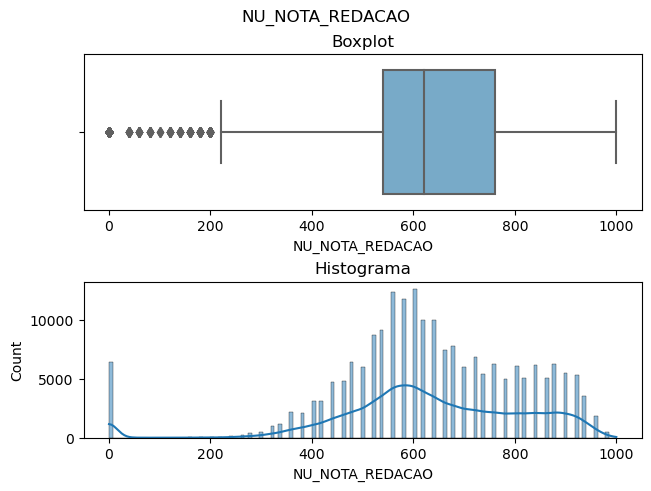

In [67]:
explore_continuous(train_data, 'NU_NOTA_REDACAO')

### **NU_NOTA_COMP2**

count    207391.000000
mean        141.484635
std          45.423535
min           0.000000
25%         120.000000
50%         120.000000
75%         180.000000
max         200.000000
Name: NU_NOTA_COMP2, dtype: float64 

Nulos: 0 



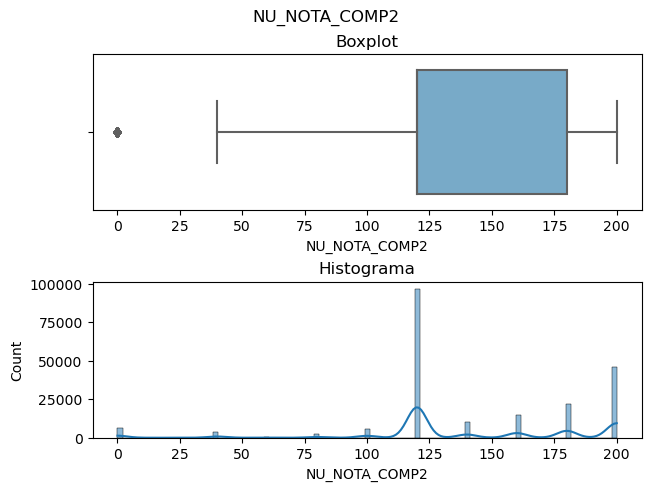

In [68]:
explore_continuous(train_data, 'NU_NOTA_COMP2')

### **NU_NOTA_MT**

count    207391.000000
mean        544.644527
std         112.019510
min           0.000000
25%         451.400000
50%         528.100000
75%         627.600000
max         953.100000
Name: NU_NOTA_MT, dtype: float64 

Nulos: 0 



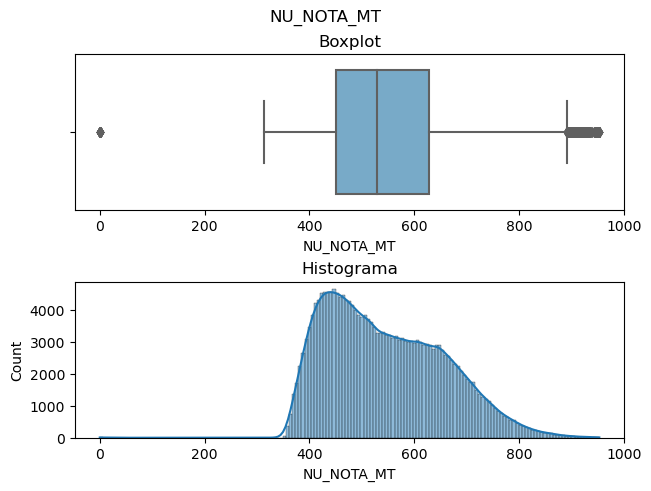

In [69]:
explore_continuous(train_data, 'NU_NOTA_MT')

### **NU_NOTA_COMP5**

count    207391.000000
mean        118.101653
std          60.127588
min           0.000000
25%          80.000000
50%         120.000000
75%         160.000000
max         200.000000
Name: NU_NOTA_COMP5, dtype: float64 

Nulos: 0 



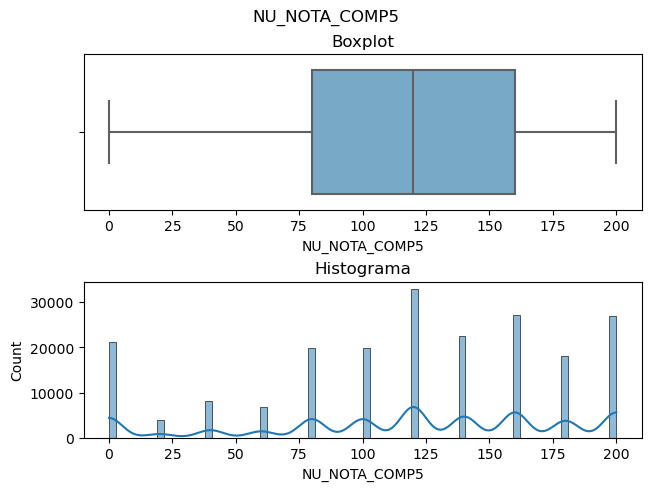

In [70]:
explore_continuous(train_data, 'NU_NOTA_COMP5')

### **MF**

count    207391.000000
mean        539.704116
std          91.092054
min          72.020000
25%         473.720000
50%         533.700000
75%         602.760000
max         845.400000
Name: MF, dtype: float64 

Nulos: 0 



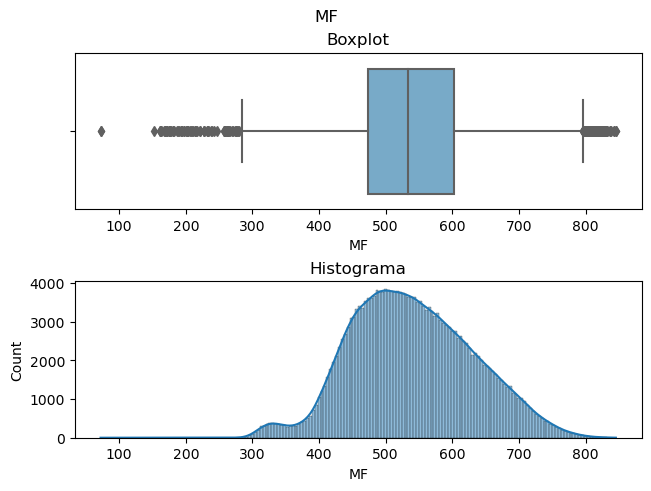

In [71]:
explore_continuous(train_data, 'MF')

### **NU_NOTA_COMP1**

In [72]:
explore_continuous(train_data, 'NU_NOTA_COMP1')

count    207391.000000
mean        121.328409
std          33.466806
min           0.000000
25%         100.000000
50%         120.000000
75%         140.000000
max         200.000000
Name: NU_NOTA_COMP1, dtype: float64 

Nulos: 0 



### **NU_NOTA_COMP4**

count    207391.000000
mean        131.309555
std          38.806650
min           0.000000
25%         120.000000
50%         120.000000
75%         160.000000
max         200.000000
Name: NU_NOTA_COMP4, dtype: float64 

Nulos: 0 



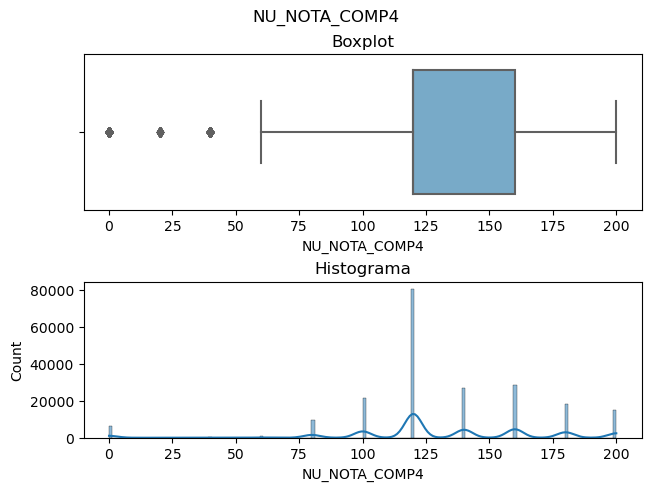

In [73]:
explore_continuous(train_data, 'NU_NOTA_COMP4')

### **NU_NOTA_LC**

In [74]:
explore_continuous(train_data, 'NU_NOTA_LC')

count    207391.000000
mean        507.253748
std          76.612217
min           0.000000
25%         454.800000
50%         511.100000
75%         562.000000
max         820.500000
Name: NU_NOTA_LC, dtype: float64 

Nulos: 0 



### **NU_NOTA_CH**

count    207391.000000
mean        523.073412
std          92.542014
min           0.000000
25%         450.800000
50%         526.400000
75%         590.500000
max         846.900000
Name: NU_NOTA_CH, dtype: float64 

Nulos: 0 



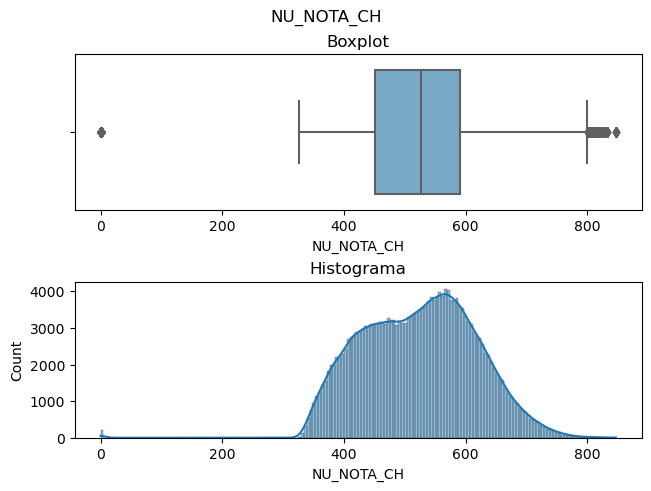

In [75]:
explore_continuous(train_data, 'NU_NOTA_CH')

### **NU_NOTA_CN**

count    207391.000000
mean        493.653385
std          80.825144
min           0.000000
25%         431.400000
50%         485.000000
75%         550.800000
max         844.500000
Name: NU_NOTA_CN, dtype: float64 

Nulos: 0 



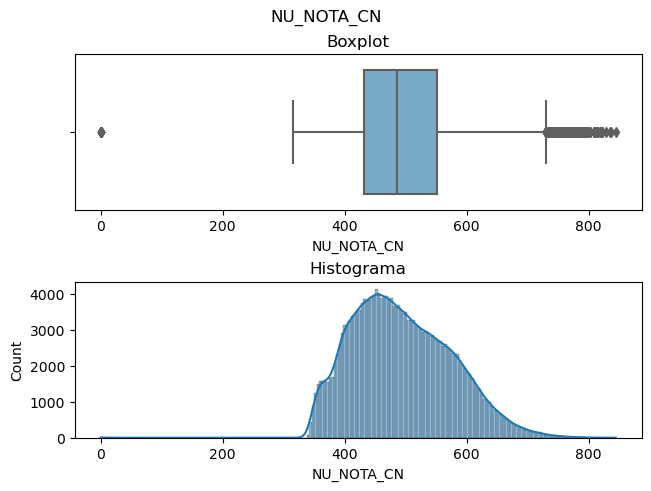

In [76]:
explore_continuous(train_data, 'NU_NOTA_CN')

## **Explorando o label**

In [77]:
def explore_label(data, variable):
    counts = data[variable].value_counts().sort_index(ascending=True)
    print(counts, '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, ax = plt.subplots(constrained_layout=True)
    sns.countplot(ax=ax, x=data[variable], palette='Blues', order=counts.index)
    plt.show()

### **CONCEITO**

A      164
B     9538
C    43879
D    79333
E    74477
Name: CONCEITO, dtype: int64 

Nulos: 0 



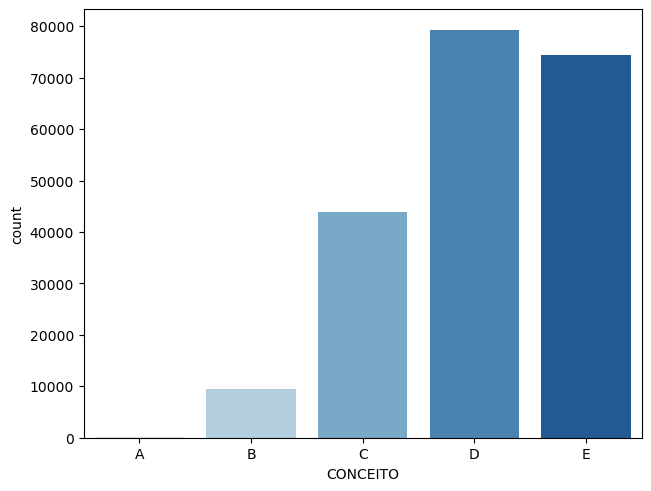

In [78]:
explore_label(train_data, 'CONCEITO')

# **Limpeza e pré-processamento dos dados**

- **Features com apenas uma classe:** NU_ANO, TP_ST_CONCLUSAO, IN_TREINEIRO, TP_PRESENCA_CN, TP_PRESENCA_CH, TP_PRESENCA_LC, TP_PRESENCA_MT

In [9]:
drop_features2 = ['NU_ANO', 'TP_ST_CONCLUSAO', 'IN_TREINEIRO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']

train_data = train_data.drop(columns=drop_features2)
train_data.head()

TP_FAIXA_ETARIA TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  \
ID                                                               
2464336                3       F                1            1   
1983774                4       M                1            3   
1440554                3       M                1            3   
2522015                2       M                1            3   
3274277                3       F                1            1   

         TP_NACIONALIDADE  TP_ESCOLA  TP_ENSINO  CO_MUNICIPIO_ESC  CO_UF_ESC  \
ID                                                                             
2464336                 1          2        1.0         4322707.0       43.0   
1983774                 1          2        1.0         3303500.0       33.0   
1440554                 1          2        1.0         2408102.0       24.0   
2522015                 1          2        1.0         2306405.0       23.0   
3274277                 1          2        1.0         3520509.0       35.0   

         TP_DEPENDENCIA_ADM_ESC  ...  Q018  Q019  Q020  Q021  Q022  Q023  \
ID                               ...                                       
2464336                     2.0  ...     B     C     A     A     E     A   
1983774                     2.0  ...     A     B     A     B     B     A   
1440554                     1.0  ...     A     C     A     A     E     A   
2522015                     2.0  ...     A     B     A     A     B     A   
3274277                     2.0  ...     A     B     A     A     D     A   

         Q024  Q025      MF  CONCEITO  
ID                                     
2464336     B     B  608.46         C  
1983774     A     A  362.88         E  
1440554     B     B  681.82         C  
2522015     A     A  462.20         E  
3274277     A     B  506.72         D  

[5 rows x 57 columns]

In [10]:
boolean_features = list(set(boolean_features) - set(drop_features2))
ordinal_features = list(set(ordinal_features) - set(drop_features2))
nominal_features = list(set(nominal_features) - set(drop_features2))
discrete_features = list(set(discrete_features) - set(drop_features2))
continuous_features = list(set(continuous_features) - set(drop_features2))
label_features = list(set(label_features) - set(drop_features2))
all_features = list(set(all_features) - set(drop_features2))

In [11]:
class BooleanEncoder(BaseEstimator, TransformerMixin):
    """
    Processa os valores booleanos dos labels.\n
    Ao instanciar o transformador, é necessário colocar como parâmetros o valor correspondente à `True` como `true_value`
    e o à `False` como `false_value`.\n
    Exemplo:\n
    BooleanEncoder(true_value='', false_value='')
    """
    def __init__(self, true_value, false_value):
        super().__init__()
        self.true_value = true_value
        self.false_value = false_value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.replace(self.true_value, 1)
        X = X.replace(self.false_value, 0)
        
        X = X.astype(int)
        
        return X



class NumericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X



class LabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.replace({
            'E': 0,
            'D': 1,
            'C': 2,
            'B': 3,
            'A': 4,
        })
        
        X = X.astype(int)
        
        return X
    
    def inverse_transform(self, X, y=None):
        X = X.replace({
            0: 'E',
            1: 'D',
            2: 'C',
            3: 'B',
            4: 'A',
        })

        X = X.astype(object)

        return X

In [12]:
def get_preprocessors():
    boolean_transformer = Pipeline(steps=[
        ('encoder', BooleanEncoder(true_value='B', false_value='A')),
    ])

    ordinal_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder()),
    ])

    nominal_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder()),
    ])

    discrete_transformer = Pipeline(steps=[
        ('encoder', NumericalEncoder()),
    ])

    continuous_transformer = Pipeline(steps=[
        ('encoder', NumericalEncoder()),
    ])

    X_transformers = ColumnTransformer(transformers=[
        ('boolean', boolean_transformer, boolean_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('nominal', nominal_transformer, nominal_features),
        ('discrete', discrete_transformer, discrete_features),
        ('continuous', continuous_transformer, continuous_features),
    ])

    X_preprocessor = Pipeline(steps=[
        ('transformers', X_transformers),
        ('scaler', MinMaxScaler()),
    ])

    y_preprocessor = Pipeline(steps=[
        ('transformers', LabelEncoder()),
    ])

    return X_preprocessor, y_preprocessor

X_preprocessor, y_preprocessor = get_preprocessors()

## **Seleção de variáveis**

In [13]:
def get_preprocessor_feature_names(preprocessor, data):
    """
    Retorna o nome das features de um DataFrame após o preprocessamento. Devem ser informados os parâmetros `preprocessor` e `data`.
    """
    preprocessor_columns = list()


    for transformer in preprocessor[0].transformers:
        transformer_columns = transformer[2]

        if 'encoder' in transformer[1].named_steps:
            if isinstance(transformer[1].named_steps['encoder'], OneHotEncoder):
                for column in transformer_columns:
                    onehot_categories = sorted(list(data[column].value_counts().index))
                    
                    for category in onehot_categories:
                            preprocessor_columns.append(f'{column}_{category}')
            else:
                preprocessor_columns.extend(transformer_columns)
        else:
            preprocessor_columns.extend(transformer_columns)
    

    return preprocessor_columns

# get_preprocessor_feature_names(preprocessor, train_data)

In [14]:
def get_X_y(data):
    X = data.drop(columns='CONCEITO')
    y = data['CONCEITO'].reset_index(drop=True)
    return X, y

def preprocess_X(X, X_preprocessor):
    X_as_num = X_preprocessor.fit_transform(X)
    X_as_num = pd.DataFrame(X_as_num, columns=get_preprocessor_feature_names(X_preprocessor, X))
    return X_as_num

def preprocess_y(y, y_preprocessor):
    y_as_num = y_preprocessor.fit_transform(y)
    return y_as_num

def translate_y(y, y_preprocessor):
    translated_y = y_preprocessor.inverse_transform(y)
    return translated_y

def concat_X_y(X, y):
    data = pd.concat([X, y], axis=1)
    return data

In [15]:
X, y = get_X_y(train_data)

In [16]:
X_as_num = preprocess_X(X, X_preprocessor)
X_as_num.head()

Q021  Q020  Q025  Q023  Q018  Q011  Q022  Q017  Q007  Q015  ...  \
0   0.0   0.0   1.0   0.0   1.0  0.00  1.00   0.0   0.0   0.0  ...   
1   1.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...   
2   0.0   0.0   1.0   0.0   0.0  0.00  1.00   0.0   0.0   0.0  ...   
3   0.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...   
4   0.0   0.0   1.0   0.0   0.0  0.25  0.75   0.0   0.0   0.0  ...   

   NU_NOTA_COMP5  NU_NOTA_COMP1  NU_NOTA_COMP3  NU_NOTA_REDACAO  NU_NOTA_LC  \
0            0.7            0.6            0.6             0.72    0.606947   
1            0.0            0.0            0.0             0.00    0.509933   
2            1.0            0.8            0.8             0.92    0.719561   
3            0.0            0.6            0.4             0.42    0.633394   
4            0.8            0.6            0.6             0.64    0.649238   

   NU_NOTA_MT  NU_NOTA_CH  NU_NOTA_COMP4  NU_NOTA_COMP2        MF  
0    0.760990    0.594403            0.7            1.0  0.693631  
1    0.498479    0.563585            0.0            0.0  0.376089  
2    0.737173    0.709883            1.0            1.0  0.788487  
3    0.425873    0.575393            0.5            0.6  0.504513  
4    0.608750    0.491085            0.6            0.6  0.562078  

[5 rows x 56 columns]

In [17]:
y_as_num = preprocess_y(y, y_preprocessor)
y_as_num.head()

0    2
1    0
2    2
3    0
4    1
Name: CONCEITO, dtype: int64

In [18]:
train_data_as_num = concat_X_y(X_as_num, y_as_num)
train_data_as_num.head()

Q021  Q020  Q025  Q023  Q018  Q011  Q022  Q017  Q007  Q015  ...  \
0   0.0   0.0   1.0   0.0   1.0  0.00  1.00   0.0   0.0   0.0  ...   
1   1.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...   
2   0.0   0.0   1.0   0.0   0.0  0.00  1.00   0.0   0.0   0.0  ...   
3   0.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...   
4   0.0   0.0   1.0   0.0   0.0  0.25  0.75   0.0   0.0   0.0  ...   

   NU_NOTA_COMP1  NU_NOTA_COMP3  NU_NOTA_REDACAO  NU_NOTA_LC  NU_NOTA_MT  \
0            0.6            0.6             0.72    0.606947    0.760990   
1            0.0            0.0             0.00    0.509933    0.498479   
2            0.8            0.8             0.92    0.719561    0.737173   
3            0.6            0.4             0.42    0.633394    0.425873   
4            0.6            0.6             0.64    0.649238    0.608750   

   NU_NOTA_CH  NU_NOTA_COMP4  NU_NOTA_COMP2        MF  CONCEITO  
0    0.594403            0.7            1.0  0.693631         2  
1    0.563585            0.0            0.0  0.376089         0  
2    0.709883            1.0            1.0  0.788487         2  
3    0.575393            0.5            0.6  0.504513         0  
4    0.491085            0.6            0.6  0.562078         1  

[5 rows x 57 columns]

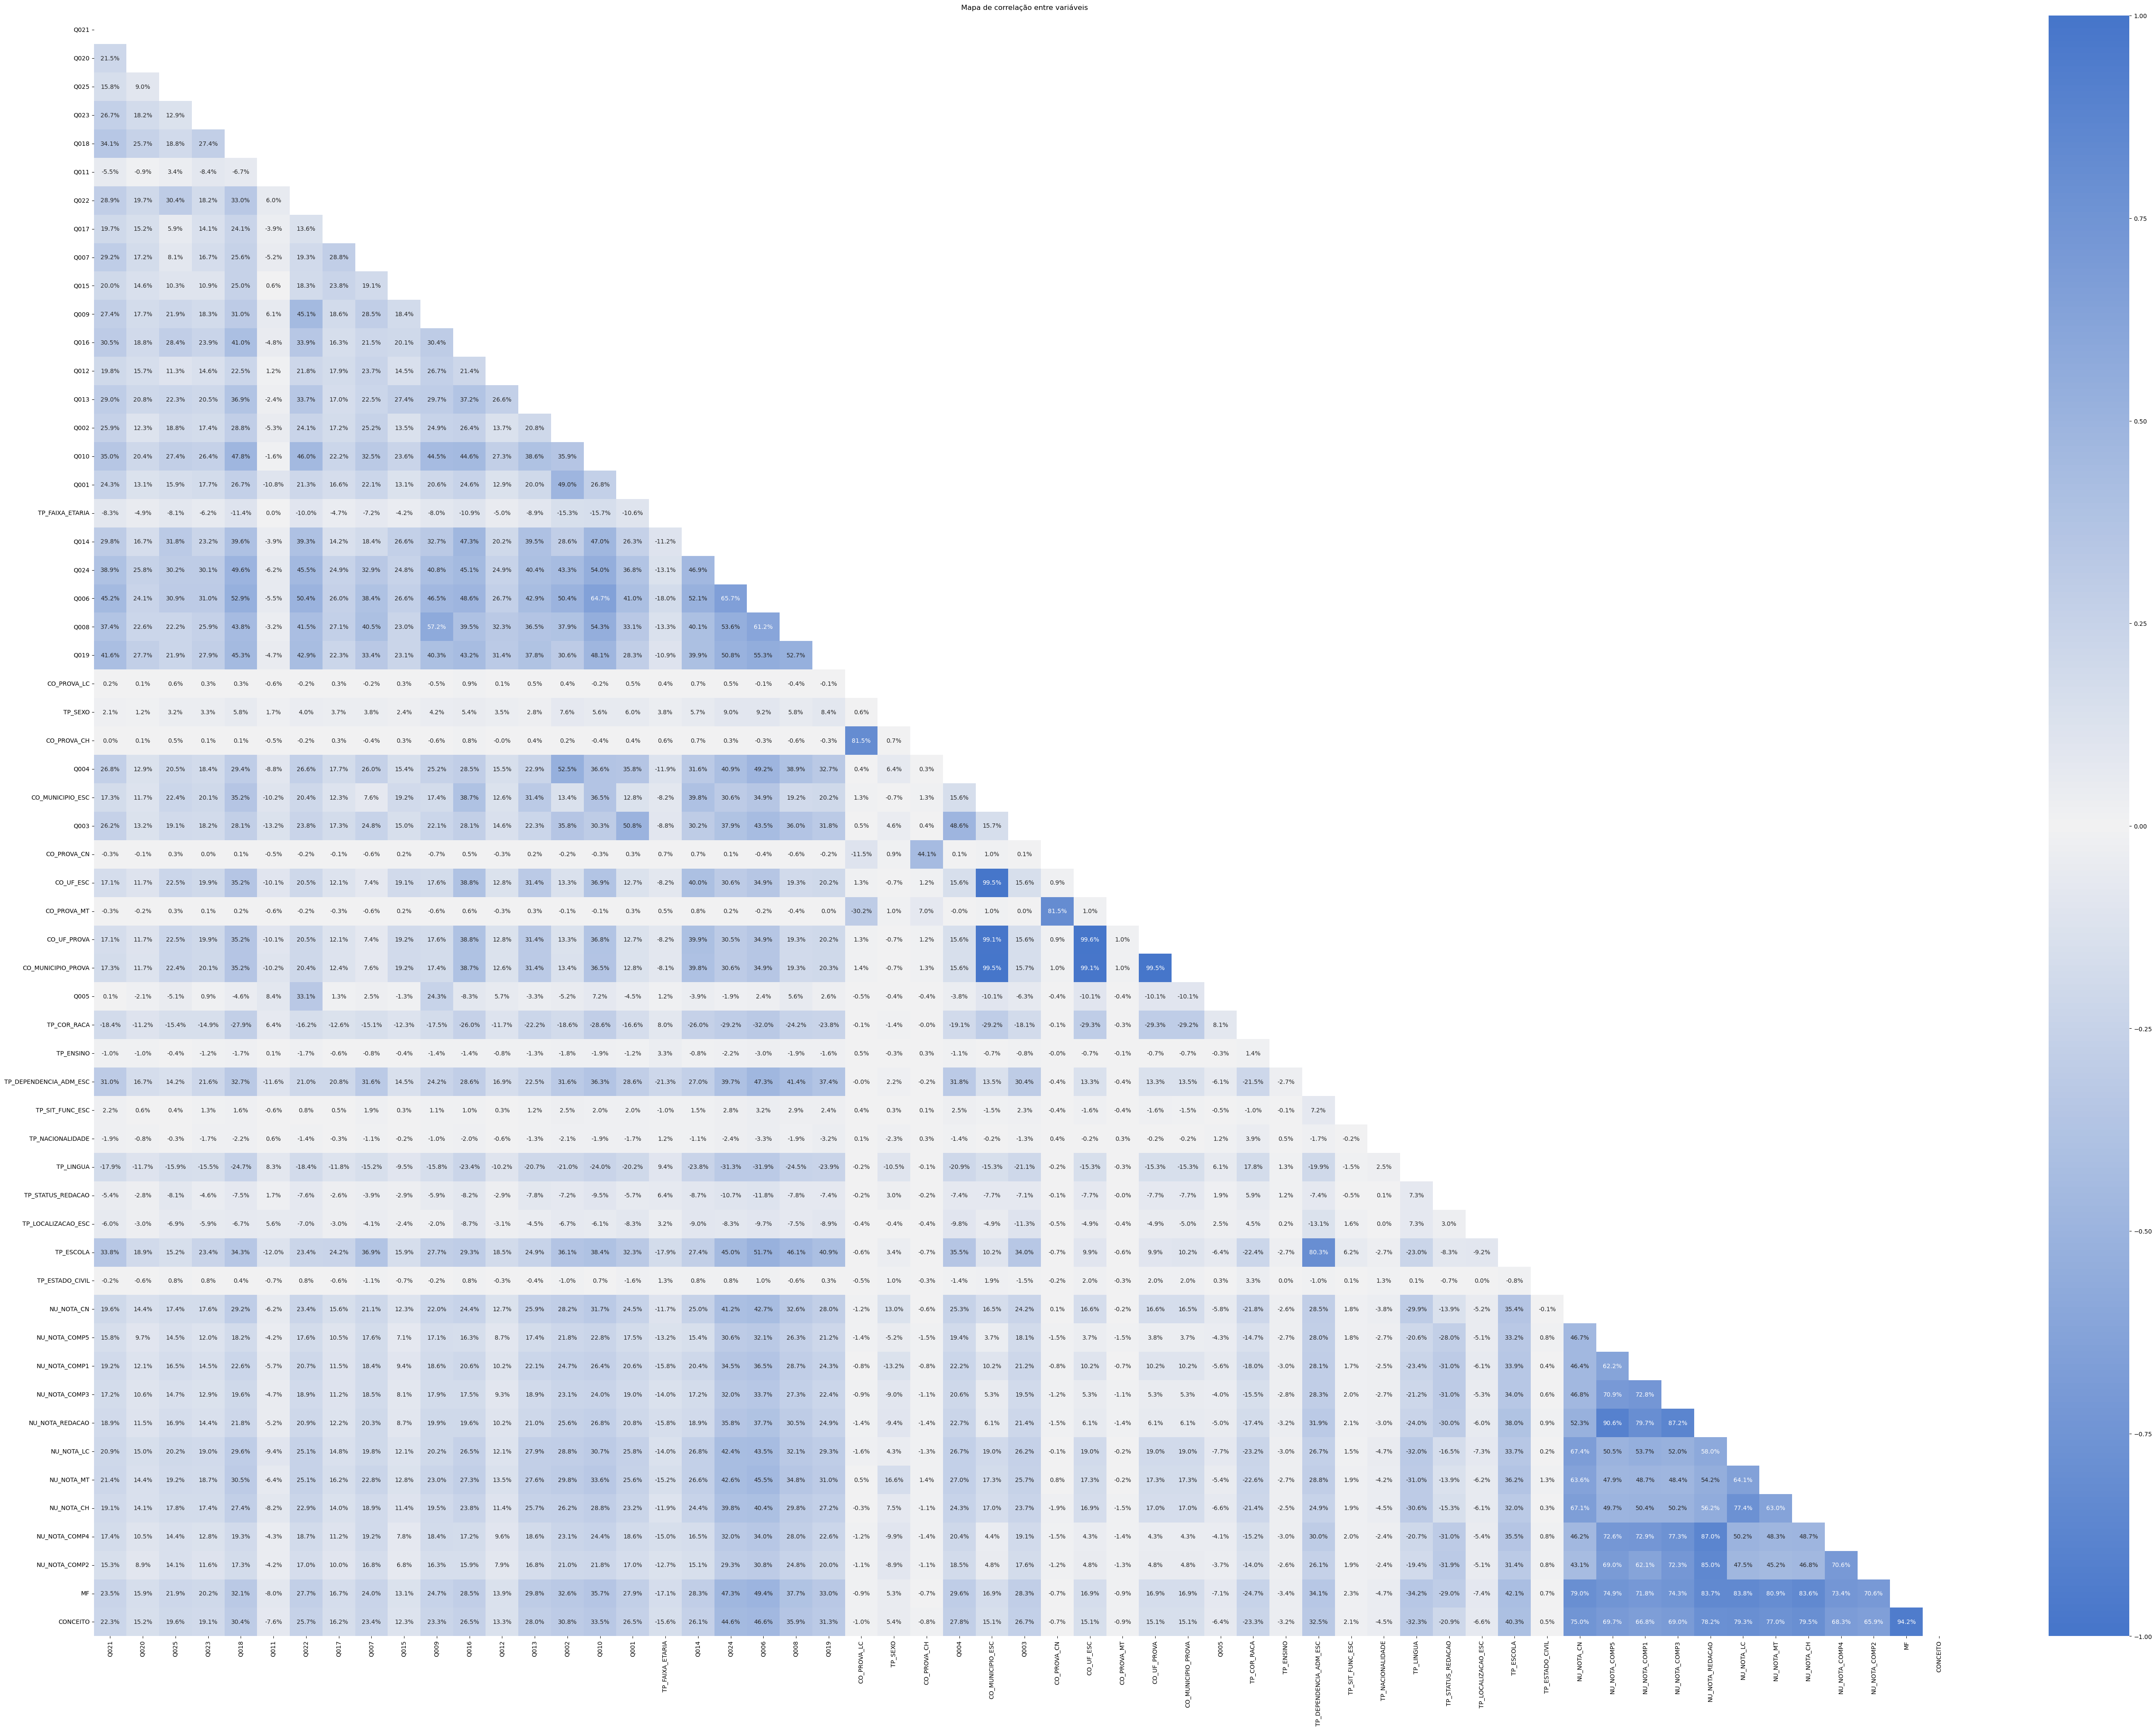

In [19]:
fig, ax = plt.subplots(figsize=(50, 40), constrained_layout=True)


def plot(ax, data, title):
    corr = data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=ax)
    graph.set_title(title, pad=10)


plot(ax, train_data_as_num, 'Mapa de correlação entre variáveis')
plt.show()

- **Variáveis altamente correlacionadas:** CO_MUNICIPIO_ESC, CO_MUNICIPIO_PROVA

In [20]:
drop_features3 = ['CO_MUNICIPIO_ESC', 'CO_MUNICIPIO_PROVA']

train_data = train_data.drop(columns=drop_features3)
train_data_as_num = train_data_as_num.drop(columns=drop_features3)
train_data_as_num.head()

Q021  Q020  Q025  Q023  Q018  Q011  Q022  Q017  Q007  Q015  ...  \
0   0.0   0.0   1.0   0.0   1.0  0.00  1.00   0.0   0.0   0.0  ...   
1   1.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...   
2   0.0   0.0   1.0   0.0   0.0  0.00  1.00   0.0   0.0   0.0  ...   
3   0.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...   
4   0.0   0.0   1.0   0.0   0.0  0.25  0.75   0.0   0.0   0.0  ...   

   NU_NOTA_COMP1  NU_NOTA_COMP3  NU_NOTA_REDACAO  NU_NOTA_LC  NU_NOTA_MT  \
0            0.6            0.6             0.72    0.606947    0.760990   
1            0.0            0.0             0.00    0.509933    0.498479   
2            0.8            0.8             0.92    0.719561    0.737173   
3            0.6            0.4             0.42    0.633394    0.425873   
4            0.6            0.6             0.64    0.649238    0.608750   

   NU_NOTA_CH  NU_NOTA_COMP4  NU_NOTA_COMP2        MF  CONCEITO  
0    0.594403            0.7            1.0  0.693631         2  
1    0.563585            0.0            0.0  0.376089         0  
2    0.709883            1.0            1.0  0.788487         2  
3    0.575393            0.5            0.6  0.504513         0  
4    0.491085            0.6            0.6  0.562078         1  

[5 rows x 55 columns]

In [21]:
boolean_features = list(set(boolean_features) - set(drop_features3))
ordinal_features = list(set(ordinal_features) - set(drop_features3))
nominal_features = list(set(nominal_features) - set(drop_features3))
discrete_features = list(set(discrete_features) - set(drop_features3))
continuous_features = list(set(continuous_features) - set(drop_features3))
label_features = list(set(label_features) - set(drop_features3))
all_features = list(set(all_features) - set(drop_features3))

In [22]:
fig, ax = plt.subplots(figsize=(50, 40), constrained_layout=True)


def plot(ax, data, title):
    corr = data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=ax)
    graph.set_title(title, pad=10)


plot(ax, train_data_as_num, 'Mapa de correlação entre variáveis')
plt.show()

- **Variáveis com data leaking:** CO_PROVA_CN, CO_PROVA_MT, CO_PROVA_CH, CO_PROVA_LC, NU_NOTA_MT, MF, NU_NOTA_COMP2, NU_NOTA_CH, NU_NOTA_COMP1, NU_NOTA_REDACAO, NU_NOTA_COMP4, NU_NOTA_LC, NU_NOTA_COMP3, NU_NOTA_CN, NU_NOTA_COMP5, TP_LINGUA, TP_STATUS_REDACAO

In [23]:
drop_features4 = ['CO_PROVA_CN', 'CO_PROVA_MT', 'CO_PROVA_CH', 'CO_PROVA_LC', 'NU_NOTA_MT', 'MF', 'NU_NOTA_COMP2', 'NU_NOTA_CH', 'NU_NOTA_COMP1', 'NU_NOTA_REDACAO', 'NU_NOTA_COMP4', 'NU_NOTA_LC', 'NU_NOTA_COMP3', 'NU_NOTA_CN', 'NU_NOTA_COMP5', 'TP_LINGUA', 'TP_STATUS_REDACAO']

train_data = train_data.drop(columns=drop_features4)
train_data_as_num = train_data_as_num.drop(columns=drop_features4)
train_data_as_num.head()

Q021  Q020  Q025  Q023  Q018  Q011  Q022  Q017  Q007  Q015  ...      Q005  \
0   0.0   0.0   1.0   0.0   1.0  0.00  1.00   0.0   0.0   0.0  ...  0.157895   
1   1.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...  0.052632   
2   0.0   0.0   1.0   0.0   0.0  0.00  1.00   0.0   0.0   0.0  ...  0.157895   
3   0.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...  0.105263   
4   0.0   0.0   1.0   0.0   0.0  0.25  0.75   0.0   0.0   0.0  ...  0.105263   

   TP_COR_RACA  TP_ENSINO  TP_DEPENDENCIA_ADM_ESC  TP_SIT_FUNC_ESC  \
0          0.2        0.0                0.333333              0.0   
1          0.6        0.0                0.333333              0.0   
2          0.6        0.0                0.000000              0.0   
3          0.6        0.0                0.333333              0.0   
4          0.2        0.0                0.333333              0.0   

   TP_NACIONALIDADE  TP_LOCALIZACAO_ESC  TP_ESCOLA  TP_ESTADO_CIVIL  CONCEITO  
0              0.25                 0.0        0.0             0.25         2  
1              0.25                 0.0        0.0             0.25         0  
2              0.25                 0.0        0.0             0.25         2  
3              0.25                 1.0        0.0             0.25         0  
4              0.25                 0.0        0.0             0.25         1  

[5 rows x 38 columns]

In [24]:
boolean_features = list(set(boolean_features) - set(drop_features4))
ordinal_features = list(set(ordinal_features) - set(drop_features4))
nominal_features = list(set(nominal_features) - set(drop_features4))
discrete_features = list(set(discrete_features) - set(drop_features4))
continuous_features = list(set(continuous_features) - set(drop_features4))
label_features = list(set(label_features) - set(drop_features4))
all_features = list(set(all_features) - set(drop_features4))

In [25]:
fig, ax = plt.subplots(figsize=(50, 40), constrained_layout=True)


def plot(ax, data, title):
    corr = data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=ax)
    graph.set_title(title, pad=10)


plot(ax, train_data_as_num, 'Mapa de correlação entre variáveis')
plt.show()

- **Variável altamente correlacionada e data leakage:** CO_UF_PROVA

In [26]:
drop_features5 = ['CO_UF_PROVA']

train_data = train_data.drop(columns=drop_features5)
train_data_as_num = train_data_as_num.drop(columns=drop_features5)
train_data_as_num.head()

Q021  Q020  Q025  Q023  Q018  Q011  Q022  Q017  Q007  Q015  ...      Q005  \
0   0.0   0.0   1.0   0.0   1.0  0.00  1.00   0.0   0.0   0.0  ...  0.157895   
1   1.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...  0.052632   
2   0.0   0.0   1.0   0.0   0.0  0.00  1.00   0.0   0.0   0.0  ...  0.157895   
3   0.0   0.0   0.0   0.0   0.0  0.00  0.25   0.0   0.0   0.0  ...  0.105263   
4   0.0   0.0   1.0   0.0   0.0  0.25  0.75   0.0   0.0   0.0  ...  0.105263   

   TP_COR_RACA  TP_ENSINO  TP_DEPENDENCIA_ADM_ESC  TP_SIT_FUNC_ESC  \
0          0.2        0.0                0.333333              0.0   
1          0.6        0.0                0.333333              0.0   
2          0.6        0.0                0.000000              0.0   
3          0.6        0.0                0.333333              0.0   
4          0.2        0.0                0.333333              0.0   

   TP_NACIONALIDADE  TP_LOCALIZACAO_ESC  TP_ESCOLA  TP_ESTADO_CIVIL  CONCEITO  
0              0.25                 0.0        0.0             0.25         2  
1              0.25                 0.0        0.0             0.25         0  
2              0.25                 0.0        0.0             0.25         2  
3              0.25                 1.0        0.0             0.25         0  
4              0.25                 0.0        0.0             0.25         1  

[5 rows x 37 columns]

In [27]:
boolean_features = list(set(boolean_features) - set(drop_features5))
ordinal_features = list(set(ordinal_features) - set(drop_features5))
nominal_features = list(set(nominal_features) - set(drop_features5))
discrete_features = list(set(discrete_features) - set(drop_features5))
continuous_features = list(set(continuous_features) - set(drop_features5))
label_features = list(set(label_features) - set(drop_features5))
all_features = list(set(all_features) - set(drop_features5))

In [28]:
fig, ax = plt.subplots(figsize=(50, 40), constrained_layout=True)


def plot(ax, data, title):
    corr = data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=ax)
    graph.set_title(title, pad=10)


plot(ax, train_data_as_num, 'Mapa de correlação entre variáveis')
plt.show()

In [29]:
X_as_num, y_as_num = get_X_y(train_data_as_num)

# **Seleção do modelo**

## **Pré-processamento dos dados**

In [30]:
X_preprocessor, y_preprocessor = get_preprocessors()

In [31]:
X = pd.DataFrame(X, columns=X_as_num.columns)
X_as_num = preprocess_X(X, X_preprocessor)
X_as_num.head()

Q021  Q020  Q025  Q023  Q018  Q022  Q017  Q015  Q016    Q006  ...  Q004  \
0   0.0   0.0   1.0   0.0   1.0  1.00   0.0   0.0  0.00  0.4375  ...   0.0   
1   1.0   0.0   0.0   0.0   0.0  0.25   0.0   0.0  0.00  0.0625  ...   0.2   
2   0.0   0.0   1.0   0.0   0.0  1.00   0.0   0.0  0.25  0.1875  ...   0.2   
3   0.0   0.0   0.0   0.0   0.0  0.25   0.0   0.0  0.00  0.0625  ...   0.0   
4   0.0   0.0   1.0   0.0   0.0  0.75   0.0   0.0  0.25  0.1875  ...   0.4   

       Q005  TP_COR_RACA  TP_ENSINO  TP_DEPENDENCIA_ADM_ESC  TP_SIT_FUNC_ESC  \
0  0.157895          0.2        0.0                0.333333              0.0   
1  0.052632          0.6        0.0                0.333333              0.0   
2  0.157895          0.6        0.0                0.000000              0.0   
3  0.105263          0.6        0.0                0.333333              0.0   
4  0.105263          0.2        0.0                0.333333              0.0   

   TP_NACIONALIDADE  TP_LOCALIZACAO_ESC  TP_ESCOLA  TP_ESTADO_CIVIL  
0              0.25                 0.0        0.0             0.25  
1              0.25                 0.0        0.0             0.25  
2              0.25                 0.0        0.0             0.25  
3              0.25                 1.0        0.0             0.25  
4              0.25                 0.0        0.0             0.25  

[5 rows x 36 columns]

In [32]:
y_as_num.head()

0    2
1    0
2    2
3    0
4    1
Name: CONCEITO, dtype: int64

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_as_num, y_as_num, train_size=0.8, random_state=SEED)

## **Modelos**

### **Dummy**

In [34]:
dummy = DummyClassifier(strategy='most_frequent', random_state=SEED)

In [35]:
dummy.fit(X_train, y_train)

DummyClassifier(random_state=3, strategy='most_frequent')

In [36]:
dummy_scores = cross_val_score(dummy, X_as_num, y_as_num, cv=5, scoring='accuracy')
dummy_scores.mean()

0.38252865371131356

### **SVC**

In [50]:
svc = SVC(random_state=SEED)

In [51]:
svc.fit(X_train, y_train)

SVC(random_state=3)

In [65]:
svc_val_predictions = svc.predict(X_val)

In [66]:
print(f'Accuracy: {accuracy_score(y_val, svc_val_predictions)}')

Accuracy: 0.523783119168736


In [73]:
svc_scores = cross_val_score(svc, X_as_num, y_as_num, cv=5, scoring='accuracy')
svc_scores.mean()

0.5235521057056518

In [60]:
joblib.dump(svc, 'models/v2/svc.joblib')

['models/v2/svc.joblib']

In [63]:
svc = joblib.load('models/v2/svc.joblib')

### **Logistic Regression**

In [ ]:
logistic_reg = LogisticRegression(max_iter=10000, random_state=SEED)

In [ ]:
logistic_reg.fit(X_train, y_train)

In [67]:
logistic_reg_scores = cross_val_score(logistic_reg, X_as_num, y_as_num, cv=5, scoring='accuracy')
logistic_reg_scores.mean()

0.5096845813680794

In [ ]:
sio.dump(logistic_reg, 'models/v2/logistic_reg.skops')

In [5]:
logistic_reg = sio.load('models/v2/logistic_reg.skops', trusted=True)

### **AdaBoost**

In [ ]:
adaboost = AdaBoostClassifier(random_state=SEED)

In [ ]:
adaboost.fit(X_train, y_train)

In [68]:
adaboost_scores = cross_val_score(adaboost, X_as_num, y_as_num, cv=5, scoring='accuracy')
adaboost_scores.mean()

0.5220043202458893

In [ ]:
sio.dump(adaboost, 'models/v2/adaboost.skops')

In [6]:
adaboost = sio.load('models/v2/adaboost.skops', trusted=True)

### **KNN**

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train, y_train)

In [69]:
knn_scores = cross_val_score(knn, X_as_num, y_as_num, cv=5, scoring='accuracy')
knn_scores.mean()

0.45948955705059163

In [ ]:
sio.dump(knn, 'models/v2/knn.skops')

In [7]:
knn = sio.load('models/v2/knn.skops', trusted=True)

### **DecisionTree**

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=SEED)

In [ ]:
decision_tree.fit(X_train, y_train)

In [70]:
decision_tree_scores = cross_val_score(decision_tree, X_as_num, y_as_num, cv=5, scoring='accuracy')
decision_tree_scores.mean()

0.4212477875223433

In [ ]:
sio.dump(decision_tree, 'models/v2/decision_tree.skops')

In [8]:
decision_tree = sio.load('models/v2/decision_tree.skops', trusted=True)

### **RandomForest**

In [55]:
random_forest = RandomForestClassifier(random_state=SEED)

In [56]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=3)

In [57]:
random_forest_scores = cross_val_score(random_forest, X_as_num, y_as_num, cv=5, scoring='accuracy')
random_forest_scores.mean()

0.5172451845344908

In [60]:
random_forest_feature_importances = pd.DataFrame(random_forest.feature_importances_, index=random_forest.feature_names_in_, columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)
random_forest_feature_importances.head()

Feature Importance
CO_UF_ESC            0.090809
Q006                 0.080008
Q001                 0.055347
Q005                 0.053516
Q002                 0.049850

In [59]:
sio.dump(random_forest, 'models/v2/random_forest.skops')

In [37]:
random_forest = sio.load('models/v2/random_forest.skops', trusted=True)

### **Neural Network**

In [ ]:
neural_net = MLPClassifier(max_iter=10000, random_state=SEED)

In [ ]:
neural_net.fit(X_train, y_train)

In [72]:
neural_net_scores = cross_val_score(neural_net, X_as_num, y_as_num, cv=5, scoring='accuracy')
neural_net_scores.mean()

0.527530105126253

In [ ]:
sio.dump(neural_net, 'models/v2/neural_net.skops')

In [65]:
neural_net = sio.load('models/v2/neural_net.skops', trusted=True)

### **Resumo**

In [74]:
model_results = {
    'Models': ['SVC', 'Logistic Regression', 'AdaBoost', 'KNN', 'DecisionTree', 'RandomForest', 'Neural Network'],
    'Accuracy': [svc_scores.mean(), logistic_reg_scores.mean(), adaboost_scores.mean(), knn_scores.mean(), decision_tree_scores.mean(), random_forest_scores.mean(), neural_net_scores.mean()],
}
model_results = pd.DataFrame.from_dict(model_results)
model_results = model_results.sort_values('Accuracy', ascending=False)
model_results

Models  Accuracy
6       Neural Network  0.527530
0                  SVC  0.523552
2             AdaBoost  0.522004
5         RandomForest  0.518455
1  Logistic Regression  0.509685
3                  KNN  0.459490
4         DecisionTree  0.421248

## **Tunando melhores modelos**

### **Neural Network**

In [75]:
tuned_neural_net = MLPClassifier(max_iter=10000, random_state=SEED)

In [76]:
neural_net_param_grid = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

neural_net_grid_search = RandomizedSearchCV(tuned_neural_net, neural_net_param_grid, cv=KFold(n_splits=5), n_iter=20, random_state=SEED)

In [77]:
neural_net_grid_search.fit(X_train, y_train)

In [ ]:
neural_net_grid_search.best_params_

In [ ]:
tuned_neural_net = neural_net_grid_search.best_estimator_

In [ ]:
tuned_neural_net_scores = cross_val_score(tuned_neural_net, X_as_num, y_as_num, cv=5, scoring='accuracy')
tuned_neural_net_scores.mean()

In [ ]:
print(f'Untuned Neural Network score: {neural_net_scores.mean()}')

In [ ]:
dump(tuned_neural_net, 'models/v2/tuned_neural_net.joblib')

### **SVC**

In [ ]:
tuned_svc = SVC(random_state=SEED)

In [ ]:
svc_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid'],
}

svc_grid_search = RandomizedSearchCV(tuned_svc, svc_param_grid, cv=KFold(n_splits=5), n_iter=20, random_state=SEED)

In [ ]:
svc_grid_search.fit(X_train, y_train)

In [ ]:
svc_grid_search.best_params_

In [ ]:
tuned_svc = svc_grid_search.best_estimator_

In [ ]:
tuned_svc_scores = cross_val_score(tuned_svc, X_as_num, y_as_num, cv=5, scoring='accuracy')
tuned_svc_scores.mean()

In [ ]:
print(f'Untuned SVC score: {svc_scores.mean()}')

In [ ]:
dump(tuned_svc, 'models/v2/tuned_svc.joblib')

### **AdaBoost**

In [ ]:
tuned_adaboost = AdaBoostClassifier(random_state=SEED)

In [ ]:
adaboost_param_grid = {
    'base_estimator__criterion': ['gini', 'entropy'],
    'base_estimator__splitter': ['best', 'random'],
    'base_estimator__max_depth': [i for i in range(2, 11, 2)],
    'base_estimator__min_samples_leaf': [5, 10],
    'n_estimators': [1, 2, 10, 50, 250, 1000],
    'learning_rate': [0.01, 0.1, 1],
}

adaboost_grid_search = RandomizedSearchCV(tuned_adaboost, adaboost_param_grid, cv=KFold(n_splits=5), n_iter=20, random_state=SEED)

In [ ]:
adaboost_grid_search.fit(X_train, y_train)

In [ ]:
adaboost_grid_search.best_params_

In [ ]:
tuned_adaboost = adaboost_grid_search.best_estimator_

In [ ]:
tuned_adaboost_scores = cross_val_score(tuned_adaboost, X_as_num, y_as_num, cv=5, scoring='accuracy')
tuned_adaboost_scores.mean()

In [ ]:
print(f'Untuned AdaBoost score: {adaboost_scores.mean()}')

In [ ]:
dump(tuned_adaboost, 'models/v2/tuned_adaboost.joblib')

# **Predição**

In [61]:
test_data

TP_FAIXA_ETARIA TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  \
0                    3       F                1            1   
1                    2       F                1            1   
2                    2       F                1            3   
3                    2       M                1            5   
4                    2       F                1            1   
...                ...     ...              ...          ...   
88877                3       F                1            3   
88878                4       M                1            1   
88879                3       F                1            3   
88880                3       M                2            2   
88881                3       F                1            2   

       TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ESCOLA  TP_ENSINO  IN_TREINEIRO  \
0                     1                2          3        1.0             0   
1                     1                2          3        1.0             0   
2                     1                2          2        1.0             0   
3                     1                2          2        1.0             0   
4                     1                2          3        1.0             0   
...                 ...              ...        ...        ...           ...   
88877                 1                2          2        1.0             0   
88878                 1                2          2        1.0             0   
88879                 1                2          2        1.0             0   
88880                 1                2          2        1.0             0   
88881                 1                2          2        1.0             0   

       CO_MUNICIPIO_ESC  ... Q019  Q020 Q021  Q022  Q023  Q024  Q025       ID  \
0             3167202.0  ...    C     A    A     E     A     B     B  1522973   
1             3547809.0  ...    B     A    A     B     A     B     B   797399   
2             3527405.0  ...    B     A    B     E     A     B     B    20668   
3             2105203.0  ...    B     A    A     D     A     A     B  2403460   
4             5208707.0  ...    C     B    B     C     A     B     B  1688333   
...                 ...  ...  ...   ...  ...   ...   ...   ...   ...      ...   
88877         1504208.0  ...    B     A    B     E     A     A     B  1469881   
88878         3506359.0  ...    C     B    B     E     A     C     B   622036   
88879         3304557.0  ...    D     A    A     E     A     C     B  1398519   
88880         3302205.0  ...    C     B    A     E     A     A     B   397766   
88881         3203320.0  ...    B     A    A     E     A     B     B  2911386   

           MF NU_ANO  
0      676.94   2020  
1      569.28   2020  
2      539.44   2020  
3      459.18   2020  
4      687.24   2020  
...       ...    ...  
88877  449.18   2020  
88878  610.94   2020  
88879  523.42   2020  
88880  366.60   2020  
88881  468.48   2020  

[88882 rows x 76 columns]

In [62]:
def order_X_test(X_test, X_train):
    return pd.DataFrame(X_test, columns=X_train.columns)

X_test = order_X_test(test_data, X_train)
X_test.head()

Q021 Q020 Q025 Q023 Q018 Q022 Q017 Q015 Q016 Q006  ... Q004 Q005  \
0    A    A    B    A    A    E    A    A    B    M  ...    D  4.0   
1    A    A    B    A    A    B    A    A    B    F  ...    F  4.0   
2    B    A    B    A    A    E    A    B    A    E  ...    B  4.0   
3    A    A    B    A    A    D    A    A    A    D  ...    A  5.0   
4    B    B    B    A    B    C    A    A    B    M  ...    E  3.0   

  TP_COR_RACA  TP_ENSINO TP_DEPENDENCIA_ADM_ESC TP_SIT_FUNC_ESC  \
0           1        1.0                    4.0             1.0   
1           1        1.0                    4.0             1.0   
2           3        1.0                    2.0             1.0   
3           5        1.0                    2.0             1.0   
4           1        1.0                    4.0             4.0   

  TP_NACIONALIDADE TP_LOCALIZACAO_ESC TP_ESCOLA TP_ESTADO_CIVIL  
0                1                1.0         3               1  
1                1                1.0         3               1  
2                1                1.0         2               1  
3                1                1.0         2               1  
4                1                1.0         3               1  

[5 rows x 36 columns]

In [63]:
X_test = X_preprocessor.transform(test_data)
X_test = pd.DataFrame(X_test, columns=get_preprocessor_feature_names(X_preprocessor, X_test))
X_test

Q021  Q020  Q025  Q023  Q018  Q022  Q017  Q015  Q016    Q006  ...  \
0       0.0   0.0   1.0   0.0   0.0  1.00   0.0  0.00  0.25  0.7500  ...   
1       0.0   0.0   1.0   0.0   0.0  0.25   0.0  0.00  0.25  0.3125  ...   
2       1.0   0.0   1.0   0.0   0.0  1.00   0.0  0.25  0.00  0.2500  ...   
3       0.0   0.0   1.0   0.0   0.0  0.75   0.0  0.00  0.00  0.1875  ...   
4       1.0   1.0   1.0   0.0   1.0  0.50   0.0  0.00  0.25  0.7500  ...   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...     ...  ...   
88877   1.0   0.0   1.0   0.0   1.0  1.00   0.0  0.25  0.25  0.3125  ...   
88878   1.0   1.0   1.0   0.0   0.0  1.00   0.0  0.25  0.25  0.2500  ...   
88879   0.0   0.0   1.0   0.0   0.0  1.00   0.0  0.00  0.00  0.3125  ...   
88880   0.0   1.0   1.0   0.0   0.0  1.00   0.0  0.25  0.00  0.3125  ...   
88881   0.0   0.0   1.0   0.0   0.0  1.00   0.0  0.00  0.25  0.1875  ...   

       Q004      Q005  TP_COR_RACA  TP_ENSINO  TP_DEPENDENCIA_ADM_ESC  \
0       0.6  0.157895          0.2        0.0                1.000000   
1       1.0  0.157895          0.2        0.0                1.000000   
2       0.2  0.157895          0.6        0.0                0.333333   
3       0.0  0.210526          1.0        0.0                0.333333   
4       0.8  0.105263          0.2        0.0                1.000000   
...     ...       ...          ...        ...                     ...   
88877   0.4  0.157895          0.6        0.0                0.333333   
88878   0.4  0.210526          0.2        0.0                0.333333   
88879   1.0  0.157895          0.6        0.0                0.333333   
88880   0.2  0.157895          0.4        0.0                0.333333   
88881   0.0  0.157895          0.4        0.0                0.333333   

       TP_SIT_FUNC_ESC  TP_NACIONALIDADE  TP_LOCALIZACAO_ESC  TP_ESCOLA  \
0                  0.0              0.25                 0.0        1.0   
1                  0.0              0.25                 0.0        1.0   
2                  0.0              0.25                 0.0        0.0   
3                  0.0              0.25                 0.0        0.0   
4                  1.0              0.25                 0.0        1.0   
...                ...               ...                 ...        ...   
88877              0.0              0.25                 0.0        0.0   
88878              0.0              0.25                 0.0        0.0   
88879              0.0              0.25                 0.0        0.0   
88880              0.0              0.25                 0.0        0.0   
88881              0.0              0.25                 1.0        0.0   

       TP_ESTADO_CIVIL  
0                 0.25  
1                 0.25  
2                 0.25  
3                 0.25  
4                 0.25  
...                ...  
88877             0.25  
88878             0.25  
88879             0.25  
88880             0.50  
88881             0.25  

[88882 rows x 36 columns]

In [66]:
test_predictions = neural_net.predict(X_test)

/Users/jvporto/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- CO_UF_PROVA

  warnings.warn(message, FutureWarning)


ValueError: X has 36 features, but MLPClassifier is expecting 37 features as input.

In [ ]:
submission_df = pd.DataFrame(test_predictions, index=test_data['ID'], columns=['Category'])
submission_df = translate_y(submission_df, y_preprocessor)
submission_df.head()

In [ ]:
submission_df.to_csv('submissions/submission_v2.csv')